<a href="https://colab.research.google.com/github/openscilabs/isda/blob/main/ISDA_1_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **ISDA — Independent Structural-Dimensionality Analysis**

This notebook implements the **ISDA** method, a structured approach to identify redundancies among objectives and reduce the effective dimensionality of the system. The method transforms distances between objectives into a *conflict graph*, extracts maximal independent sets (MIS), and organizes these solutions into structural equivalences, allowing for the selection of a non-redundant subset of objectives with combinatorial grounding.

### **Summary Pipeline**

- **Input:** matrix $(Y \in \mathbb{R}^{N \times M})$, with $N$ samples and $M$ objectives.
- **Distance matrix calculation** between objectives (by correlation, dissimilarity, or other specified metric).
- **Alpha threshold selection:** The `alpha` (significance level) for constructing the conflict graph is dynamically selected. First, a valid significance level interval $ [\alpha_{min}, \alpha_{max}] $ is estimated from the distribution of correlations in the data and in permutations (noise). Then, based on a diagnosed *statistical regime* and a *caution* factor, an `alpha` is chosen within this interval. An edge is created between $i$ and $j$ when their correlation is statistically significant at the `alpha` level, indicating redundancy.
- **Conflict graph construction:** Edges represent objectives that *cannot coexist* in an independent set.
- **Extraction of MIS (Maximal Independent Sets):** Each MIS corresponds to a maximal subset of mutually independent objectives within the graph.
- **Structural ranking:** Equivalent MIS are at the same level; smaller or structurally subordinate MIS form subsequent ranks.
- **Final selection:** Choosing a representative MIS (rank 1), reflecting the reduced dimensionality of the analyzed scenario.

The notebook executes the method on six synthetic scenarios (benchmarks), illustrating:

- total independence,
- total redundancy,
- redundant blocks,
- structural chains,
- intermediate combinations.

For each scenario, the following are displayed:
the number of MIS, their distribution in ranks, the conflict graph (with present and removed edges), and the final set of objectives selected by **MINDA**.

In [ ]:

# Basic Imports

import numpy as np
import pandas as pd
from scipy import stats


In [ ]:
# The 'caution' variable controls how aggressive or conservative the
# dimensionality reduction attempt should be. A caution value of 0 means
# an aggressive attitude that seeks smaller models at the cost of a higher risk of
# losing the ability to represent the phenomenon (i.e., discarding independent
# variables). A caution value of 1 means a conservative attitude that
# seeks a lower risk of imprecision at the cost of producing larger models (i.e.,
# accepting redundant variables in the surrogate model). Intermediate values
# between 0 and 1 represent a proportional balance between the two attitudes.

AGRESSIVE = 0
MODERATE = 0.5
CONSERVATIVE = 1

# Global variable for caution (can be set between 0 and 1)
caution = CONSERVATIVE # Default value (more cautious)

# Utilities

In [ ]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt


def _enforce_min_distance(pos, min_dist=0.28, iters=900, jitter=1e-3, seed=7):
    rng = np.random.default_rng(seed)
    nodes = list(pos.keys())
    if not nodes:
        return pos

    P = np.array([pos[n] for n in nodes], dtype=float)
    P += 1e-12 * rng.normal(size=P.shape)

    for _ in range(iters):
        moved = False
        for i in range(len(nodes)):
            for j in range(i + 1, len(nodes)):
                d = P[j] - P[i]
                dist = float(np.hypot(d[0], d[1]))
                if dist < 1e-12:
                    P[j] += rng.normal(scale=jitter, size=2)
                    moved = True
                elif dist < min_dist:
                    push = d / dist
                    delta = 0.5 * (min_dist - dist) * push
                    P[i] -= delta
                    P[j] += delta
                    moved = True
        if not moved:
            break
    return {n: P[k] for k, n in enumerate(nodes)}


def _parse_node_to_1based(x, M):
    """Accepts 0-based int, 1-based int, 'fK', and 'K'."""
    if isinstance(x, (int, np.integer)):
        xi = int(x)
        if 0 <= xi < M:
            return xi + 1
        if 1 <= xi <= M:
            return xi
        return None

    s = str(x).strip()
    if len(s) >= 2 and s[0] in ("f", "F"):
        s = s[1:]

    try:
        xi = int(s)
    except Exception:
        return None

    if 0 <= xi < M:
        return xi + 1
    if 1 <= xi <= M:
        return xi
    return None


def _extract_mis_nodes_1based(mis_entry, M):
    """
    Strict extractor (no random hunting):
      - mis_indices: list of ints (0-based or 1-based)
      - mis: list (ints/labels)
      - mis_nodes: list (ints/labels)
    Returns 1..M nodes (deduplicated, preserving order).
    """
    if not isinstance(mis_entry, dict):
        raise ValueError(f"mis_ranked item is not a dict: {type(mis_entry)}")

    raw = None
    for k in ("mis_indices", "mis", "mis_nodes"):
        if k in mis_entry and mis_entry[k] not in (None, [], ()):
            raw = mis_entry[k]
            break

    if raw is None:
        keys = sorted(mis_entry.keys())
        raise ValueError(
            "mis_ranked item does not contain MIS in any canonical key "
            "('mis_indices', 'mis', 'mis_nodes'). "
            f"Item keys: {keys}"
        )

    xs = list(raw) if isinstance(raw, (list, tuple, set)) else [raw]

    out, seen = [], set()
    for x in xs:
        u = _parse_node_to_1based(x, M)
        if u is None:
            continue
        if u not in seen:
            seen.add(u)
            out.append(u)

    return out


def plot_custom_isda_graph(
    isda_out,
    title=None,
    layout_seed=7,
    show_removed=False, # Changed to False by default as per original request
    max_removed_edges=350,
    node_size=420,
    edge_width=1.15,
    removed_width=0.9,
    font_size=9,
    figsize=(9, 7),
):
    A = np.asarray(isda_out.get("adjacency", None))
    if A is None:
        raise ValueError("isda_out['adjacency'] missing.")

    M = int(A.shape[0])
    nodes = list(range(1, M + 1))

    # --- MIS: UNIQUE and explicit source (mis_ranked) ---
    mis_ranked = isda_out.get("mis_ranked", None)
    if not isinstance(mis_ranked, list) or len(mis_ranked) == 0:
        raise ValueError(
            "isda_out['mis_ranked'] missing/empty. Required to color MIS."
        )

    best_rank = min(m.get("rank", 10**9) for m in mis_ranked)
    best_mis_entry = next(
        m for m in mis_ranked if m.get("rank", 10**9) == best_rank
    )
    mis1 = _extract_mis_nodes_1based(best_mis_entry, M)

    if len(mis1) == 0:
        keys = sorted(best_mis_entry.keys()) if isinstance(best_mis_entry, dict) else []
        raise ValueError(
            "Rank1 MIS came empty after canonical extraction. "
            "This means the pipeline is generating empty MIS (or with values outside 0..M-1 / 1..M). "
            f"rank1={best_rank}; rank1 item keys: {keys}"
        )

    mis1_set = set(mis1)

    # --- graph (nodes 1..M) ---
    G = nx.Graph()
    G.add_nodes_from(nodes)

    preserved_edges = []
    removed_edges = []
    for i in range(M):
        for j in range(i + 1, M):
            if A[i, j] != 0:
                preserved_edges.append((i + 1, j + 1))
                G.add_edge(i + 1, j + 1) # Add edges to G for layout calculations
            else:
                removed_edges.append((i + 1, j + 1))

    density = nx.density(G)

    # layout + anti-overlap
    pos = nx.spring_layout(
        G,
        seed=layout_seed,
        k=3.0 / np.sqrt(max(M, 1)),  # Slightly larger k for more separation
        iterations=1000,             # More iterations for better convergence
        scale=1.0                    # Explicit scale to fill the plot area
    )
    pos = _enforce_min_distance(pos, min_dist=0.35, iters=1200, seed=layout_seed) # Slightly larger min_dist and more iterations

    fig, ax = plt.subplots(figsize=figsize)

    # removed (subsample)
    if show_removed and removed_edges:
        draw_removed = removed_edges
        if max_removed_edges is not None and len(draw_removed) > max_removed_edges:
            step = max(1, len(draw_removed) // max_removed_edges)
            draw_removed = draw_removed[::step][:max_removed_edges]

        nx.draw_networkx_edges(
            G, pos,
            edgelist=draw_removed,
            style="dashed",
            edge_color="0.65",
            width=removed_width,
            alpha=0.45,
            ax=ax,
        )

    # neighbors of Rank1 MIS - CALCULATED HERE FOR USE IN NODE COLORING
    neigh_set = set()
    for u_mis in mis1:
        neigh_set.update([k + 1 for k in np.where(A[u_mis - 1] != 0)[0].tolist()])
    neigh_set -= mis1_set # Exclude the Rank1 MIS nodes themselves

    # Separate edges for coloring
    green_edges = []
    other_preserved_edges = []

    for u, v in preserved_edges:
        if u in mis1_set or v in mis1_set:
            green_edges.append((u, v))
        else:
            other_preserved_edges.append((u, v))

    # Draw other preserved edges (not connected to Rank 1 MIS)
    if other_preserved_edges:
        nx.draw_networkx_edges(
            G, pos,
            edgelist=other_preserved_edges,
            edge_color="0.10",  # Solid black / dark gray
            width=edge_width,
            alpha=0.85,
            ax=ax,
        )

    # Draw green edges (connected to Rank 1 MIS)
    if green_edges:
        nx.draw_networkx_edges(
            G, pos,
            edgelist=green_edges,
            edge_color="C2",  # Green
            width=edge_width,
            alpha=0.95,
            ax=ax,
        )

    # nodes (single call; color does not "disappear")
    node_colors = []
    node_border_colors = []
    label_colors = []

    for u in nodes:
        if u in mis1_set:
            node_colors.append("C2")  # Green for Rank 1 MIS
            node_border_colors.append("k")  # Black border
            label_colors.append("white")
        elif u in neigh_set:
            node_colors.append("k")  # Black for neighbors of Rank1 MIS
            node_border_colors.append("k")  # Black border
            label_colors.append("white")
        # The 'else' block for white nodes was removed, as it will never be reached


    nx.draw_networkx_nodes(
        G, pos,
        nodelist=nodes,
        node_size=node_size,
        node_color=node_colors,
        edgecolors=node_border_colors,
        linewidths=1.2,
        ax=ax,
    )

    # Labels (integers)
    for k, u in enumerate(nodes):
        x, y = pos[u]
        # Ensures that the label color is defined for all nodes to prevent IndexError if label_colors is empty or smaller
        current_label_color = "white" if (u in mis1_set or u in neigh_set) else "black"
        ax.text(
            x, y, str(u), ha="center", va="center", fontsize=font_size, color=current_label_color, zorder=10
        )

    if title is None:
        title = f"Graph — density={density:.2f} | Rank1 green | Neighbors black"
    ax.set_title(title)
    ax.axis("off")
    plt.tight_layout()

    # Return neighbors of MIS rank1 for external use (if needed)
    return {
        "mis_rank1_first": list(mis1),  # 1..M
        "neighbors_of_mis": sorted(neigh_set),  # 1..M
        "density": density,
        "n_preserved": len(preserved_edges),
        "n_removed": len(removed_edges),
        "rank1": best_rank,
        "fig": fig,
        "ax": ax,
    }

In [ ]:
import numpy as np

def explain_lastro(out, top_k=8, name=None, show_all=False, file=None):
    """
    Explains the result of reduction_lastro(out).

    Expects a dict 'out' (return_details=True) typically containing:
      - 'lastro' (float in [0,1])
      - 'F_real' (mean of max(0,R²) in the test)
      - 'F_null' (same metric under permutation)
      - 'r2_by_target' (dict: target -> R² in the test)  [optional]
      - 'mis' (list of surrogate columns/indices) [optional]

    Parameters:
      - top_k: how many worst/best targets to show
      - name: case label (string)
      - show_all: if True, prints all R² by target (if available)
      - file: stream (e.g., sys.stdout, or a file). Default: None (normal print)
    """
    def _p(x):
        if file is None:
            print(x)
        else:
            print(x, file=file)

    if out is None or not isinstance(out, dict):
        _p("explain_lastro: 'out' is invalid (expected dict).")
        return

    lastro = out.get("lastro", None)
    F_real = out.get("F_real", None)
    F_null = out.get("F_null", None)
    r2_by_target = out.get("r2_by_target", None)
    mis = out.get("mis", None)

    title = name or out.get("name") or "LASTRO (reduction_lastro)"
    if name is not None:
        title = name
    _p("\n" + "=" * 72)
    _p(title)
    _p("=" * 72)

    if mis is not None:
        _p(f"Surrogate (mis): {mis}")

    if lastro is None or F_real is None or F_null is None:
        _p("Output does not contain expected keys ('lastro', 'F_real', 'F_null').")
        _p(f"Available keys: {sorted(list(out.keys()))}")
        return

    # Derived metrics (no "magic numbers")
    gap = F_real - F_null
    denom = max(1e-15, (1.0 - F_null))  # just to avoid numerical 0; not a criterion
    lastro_recalc = np.clip(gap / denom, 0.0, 1.0)

    _p(f"lastro = {lastro:.4f}  (recalc = {lastro_recalc:.4f})")
    _p(f"F_real = {F_real:.4f}  |  F_null = {F_null:.4f}  |  gap = {gap:.4f}")
    _p("Operational interpretation:")
    _p("  - lastro≈1: surrogate reconstructs others very well, far above null.")
    _p("  - lastro≈0: surrogate does not reconstruct better than null; suspicious reduction.")
    _p("  - intermediate values: some reconstruction, but there is relevant loss.")

    # Narrative heuristic only (does not change algorithm decision)
    if lastro >= 0.9:
        _p("Short read: strong lastro (reduction tends to be safe for reconstruction).")
    elif lastro >= 0.7:
        _p("Short read: moderate lastro (reduction may work, but deserves checking).")
    else:
        _p("Short read: low lastro (high risk of surrogate being too small).")

    if isinstance(r2_by_target, dict) and len(r2_by_target) > 0:
        items = list(r2_by_target.items())
        # Sort by R² (ascending)
        items_sorted = sorted(items, key=lambda kv: (-(np.inf) if kv[1] is None else kv[1]))
        # Fix Nones
        items_sorted = [(k, (-np.inf if v is None else float(v))) for k, v in items_sorted]
        items_sorted = sorted(items_sorted, key=lambda kv: kv[1])

        # worst
        worst = items_sorted[:min(top_k, len(items_sorted))]
        best = items_sorted[-min(top_k, len(items_sorted)):] if len(items_sorted) > 1 else []

        _p("\nWorst targets (lowest R² in test):")
        for k, v in worst:
            _p(f"  {k}: R² = {v:.4f}")

        if best:
            _p("\nBest targets (highest R² in test):")
            for k, v in reversed(best):
                _p(f"  {k}: R² = {v:.4f}")

        if show_all:
            _p("\nR² by target (all):")
            for k, v in items_sorted:
                _p(f"  {k}: R² = {v:.4f}")
    else:
        _p("\nNote: 'r2_by_target' is not available; no detailing by target.")

    return {
        "lastro": float(lastro),
        "F_real": float(F_real),
        "F_null": float(F_null),
        "gap": float(gap),
        "lastro_recalc": float(lastro_recalc),
    }

# MiNDA

## Alpha

In [ ]:
# %%
# ## cell 3b - Utilities to estimate alpha interval from data

import numpy as np
from scipy import stats

def alpha_from_r(r, n):
    """Converts a correlation coefficient |r| to a two-tailed p-value (alpha)
    using Fisher's z-transformation and normal approximation.
    """
    r = float(abs(r))
    if r <= 0.0:
        return 1.0
    if r >= 0.999999:
        return 1e-12
    z = np.arctanh(r)
    se = 1.0 / np.sqrt(n - 3)
    z_stat = z / se
    p = 2.0 * (1.0 - stats.norm.cdf(abs(z_stat)))
    return float(p)

def max_abs_corr(Y):
    """Returns the largest |r_ij| among columns of Y and the correlation matrix."""
    if hasattr(Y, "values"):
        data = np.asarray(Y.values, dtype=float)
    else:
        data = np.asarray(Y, dtype=float)
    n, m = data.shape
    corr = np.corrcoef(data, rowvar=False)
    iu = np.triu_indices(m, k=1)
    vals = np.abs(corr[iu])
    r_max = float(vals.max()) if vals.size > 0 else 0.0
    return r_max, corr

def estimate_null_max_r(Y, B=500, random_state=None):
    """Estimates, via permutation, the largest |r_ij| expected under the null hypothesis."""
    if hasattr(Y, "values"):
        data = np.asarray(Y.values, dtype=float)
    else:
        data = np.asarray(Y, dtype=float)
    n, m = data.shape
    rng = np.random.default_rng(random_state)
    max_nulls = []
    for _ in range(B):
        perm = np.empty_like(data)
        for j in range(m):
            perm[:, j] = rng.permutation(data[:, j])
        corr_perm = np.corrcoef(perm, rowvar=False)
        iu = np.triu_indices(m, k=1)
        max_nulls.append(np.abs(corr_perm[iu]).max())
    max_nulls = np.asarray(max_nulls, dtype=float)
    r_max_null = float(max_nulls.max()) if max_nulls.size > 0 else 0.0
    return r_max_null, max_nulls

def estimate_alpha_interval(Y, B=500, random_state=0):
    """Estimates (alpha_min, alpha_max) from Y data.

    alpha_min: two-tailed p-value associated with the largest real |r_ij|.
    alpha_max: two-tailed p-value associated with the largest null |r_ij| (permutations).
    """
    if hasattr(Y, "values"):
        data = np.asarray(Y.values, dtype=float)
    else:
        data = np.asarray(Y, dtype=float)
    n, m = data.shape
    r_max_real, corr_real = max_abs_corr(data)
    r_max_null, null_samples = estimate_null_max_r(data, B=B, random_state=random_state)
    alpha_min = alpha_from_r(r_max_real, n)
    alpha_max = alpha_from_r(r_max_null, n)
    return alpha_min, alpha_max, r_max_real, r_max_null

In [ ]:
import numpy as np

def reduction_lastro(
    Y,
    mis,
    *,
    n_perm=20,
    test_size=0.3,
    seed=123,
    clip=True,
    return_details=True,
):
    """
    reduction_lastro(Y, mis) -> lastro (0..1) + details

    Purpose: to measure whether the final MIS (surrogate) is DIMENSIONALLY SUFFICIENT
    to reproduce other objectives (reconstruction fidelity), using
    out-of-sample validation and a permutation null.

    Definitions:
      - S = mis (set of surrogate columns)
      - For each j ∉ S: fit OLS (with intercept) Y_j ~ Y_S on training data
        and measure R² on test data => F_real = mean of max(0, R²_j).
      - Null: independently permute the rows of each column in Y_S,
        repeat the same and compute F_null.
      - lastro = clip_[0,1]( (F_real - F_null) / (1 - F_null) )

    Observations:
      - Does not use a "floor" like 1e-12, nor magic thresholds.
      - n_perm only controls the Monte Carlo precision of the null (it's not a criterion).
      - mis can be a list of names (if Y is a DataFrame) or indices (array).

    Returns:
      - If return_details=True: dict with lastro, F_real, F_null, and R² by target.
      - Otherwise: float lastro.
    """

    # --- helper: convert input and resolve MIS indices ---
    if hasattr(Y, "values") and hasattr(Y, "columns"):
        cols = list(Y.columns)
        Ymat = np.asarray(Y.values, dtype=float)
        if len(mis) == 0:
            raise ValueError("mis cannot be empty.")
        if isinstance(mis[0], str):
            S_idx = [cols.index(c) for c in mis]
        else:
            S_idx = list(map(int, mis))
        M = Ymat.shape[1]
        names = cols
    else:
        Ymat = np.asarray(Y, dtype=float)
        if Ymat.ndim != 2:
            raise ValueError("Y must be 2D (N×M).")
        if len(mis) == 0:
            raise ValueError("mis cannot be empty.")
        S_idx = list(map(int, mis))
        M = Ymat.shape[1]
        names = [f"f{i+1}" for i in range(M)]

    N = Ymat.shape[0]
    S_idx = sorted(set(S_idx))
    if any(i < 0 or i >= M for i in S_idx):
        raise ValueError("mis contains index outside of [0, M).")

    T_idx = [j for j in range(M) if j not in S_idx]  # targets to reconstruct
    if len(T_idx) == 0:
        # If MIS = all columns, "reconstruction" doesn't make sense: lastro=1 by definition.
        out = {"lastro": 1.0, "F_real": 1.0, "F_null": 0.0, "r2_real": {}, "r2_null": {}}
        return out if return_details else 1.0

    # --- split hold-out (out of sample) ---
    rng = np.random.default_rng(seed)
    idx = np.arange(N)
    rng.shuffle(idx)
    n_test = int(np.round(test_size * N))
    n_test = min(max(n_test, 1), N - 1)
    test_idx = idx[:n_test]
    train_idx = idx[n_test:]

    # --- OLS with intercept: beta = argmin ||Xb - y||² ---
    def fit_predict_r2(X_train, y_train, X_test, y_test):
        # add intercept
        Xtr = np.column_stack([np.ones((X_train.shape[0], 1)), X_train])
        Xte = np.column_stack([np.ones((X_test.shape[0], 1)), X_test])

        # solve least squares
        beta, *_ = np.linalg.lstsq(Xtr, y_train, rcond=None)
        y_hat = Xte @ beta

        # R² on test data
        ss_res = np.sum((y_test - y_hat) ** 2)
        y_mean = np.mean(y_test)
        ss_tot = np.sum((y_test - y_mean) ** 2)
        if ss_tot <= 0:
            # constant target in test: R² undefined; treat as 0 (does not inform reconstruction)
            return 0.0
        return 1.0 - (ss_res / ss_tot)

    # --- calculate F for a given design X (predictors) ---
    def compute_F_and_r2dict(X):
        X_train = X[train_idx, :]
        X_test = X[test_idx, :]
        r2 = {}
        vals = []
        for j in T_idx:
            y_train = Ymat[train_idx, j]
            y_test = Ymat[test_idx, j]
            r2_j = fit_predict_r2(X_train, y_train, X_test, y_test)
            r2[names[j]] = float(r2_j)
            vals.append(max(0.0, r2_j))
        return float(np.mean(vals)), r2

    # --- Real ---
    X_real = Ymat[:, S_idx]
    F_real, r2_real = compute_F_and_r2dict(X_real)

    # --- Null via independent permutation per MIS column ---
    r2_null_acc = {names[j]: [] for j in T_idx}
    F_null_vals = []
    for b in range(int(n_perm)):
        Xn = X_real.copy()
        # permute each MIS column independently (preserves marginal, destroys dependence)
        for c in range(Xn.shape[1]):
            perm = rng.permutation(N)
            Xn[:, c] = Xn[perm, c]
        Fb, r2b = compute_F_and_r2dict(Xn)
        F_null_vals.append(Fb)
        for k, v in r2b.items():
            r2_null_acc[k].append(v)

    F_null = float(np.mean(F_null_vals))
    r2_null = {k: float(np.mean(vs)) for k, vs in r2_null_acc.items()}

    # --- normalized lastro ---
    denom = (1.0 - F_null)
    if denom <= 0:
        lastro = 0.0 if (F_real <= F_null) else 1.0
    else:
        lastro = (F_real - F_null) / denom
    if clip:
        lastro = float(np.clip(lastro, 0.0, 1.0))
    else:
        lastro = float(lastro)

    out = {
        "lastro": lastro,
        "F_real": float(F_real),
        "F_null": float(F_null),
        "mis_size": len(S_idx),
        "M": int(M),
        "N": int(N),
        "targets_reconstructed": [names[j] for j in T_idx],
        "r2_real": r2_real,
        "r2_null": r2_null,
        "settings": {
            "n_perm": int(n_perm),
            "test_size": float(test_size),
            "seed": int(seed),
            "clip": bool(clip),
        },
    }
    return out if return_details else out["lastro"]

In [ ]:
def select_alpha(alpha_min: float, alpha_max: float, caution: float) -> float:
    """
    Selects an alpha value between alpha_min and alpha_max based on caution.

    Parameters
    ----------
    alpha_min : float
        The minimum alpha value.
    alpha_max : float
        The maximum alpha value.
    caution : float
        A value between 0 and 1, where 0 returns alpha_min (less cautious) and 1 returns alpha_max (more cautious).
        Intermediate values return a linear interpolation.

    Returns
    -------
    float
        The selected alpha value.
    """
    if not (0 <= caution <= 1):
        raise ValueError("Caution must be between 0 and 1.")

    # Linear interpolation: alpha = alpha_min * (1 - caution) + alpha_max * caution
    # This ensures that caution=0 gives alpha_min and caution=1 gives alpha_max.
    return alpha_min * (1 - caution) + alpha_max * caution

## Regime

In [ ]:
import math
from enum import IntEnum

class AlphaRegime(IntEnum):
    SIGNAL_BELOW_NOISE   = 1  # α_min > α_max
    END_OF_SCALE       = 2  # α_min = 0, α_max = 0
    IMMEDIATE_SEPARATION = 3  # α_min = 0, α_max > 0
    LIMINAL_SEPARATION        = 4  # 0 < α_min ≤ α_max


def diagnose_alpha_regime(alpha_min: float, alpha_max: float):
    """
    "Pure" diagnosis of the statistical regime + metrics, without deciding alpha_selected.

    Returns
    -------
    metrics : dict
      - regime   : int (AlphaRegime)
      - alpha_min, alpha_max : float
      - S        : float (finite), +inf or NaN
      - S_norm   : float in [0,1] in REGULAR; NaN outside it
    """

    # Decide regime
    if alpha_min > alpha_max:
        regime = AlphaRegime.SIGNAL_BELOW_NOISE
        # S exists (negative), but it's not an interpretable metric; it's still a valid number.
        try:
            S = math.log(alpha_max / alpha_min)
        except ValueError:
            S = math.nan
        S_norm = math.nan

    elif alpha_min == 0 and alpha_max == 0:
        regime = AlphaRegime.END_OF_SCALE
        S = math.nan
        S_norm = math.nan

    elif alpha_min == 0 and alpha_max > 0:
        regime = AlphaRegime.IMMEDIATE_SEPARATION
        S = math.inf
        S_norm = math.nan

    else:
        # REGULAR: 0 < alpha_min <= alpha_max
        regime = AlphaRegime.LIMINAL_SEPARATION
        S = math.log(alpha_max / alpha_min)
        S_norm = S / math.log(1.0 / alpha_min)

    return {
        "regime": int(regime),
        "alpha_min": alpha_min,
        "alpha_max": alpha_max,
        "S": S,
        "S_norm": S_norm,
    }

In [ ]:
def describe_alpha_regime(metrics: dict) -> str:
    """
    Generates a human-readable text (ready for print) with:
    regime condition, interpretation, action on MIS, and meanings of S and S_norm.

    Note: this function DOES NOT select alpha_selected; that is decided externally, based on the regime.
    """

    regime = AlphaRegime(int(metrics["regime"]))
    alpha_min = float(metrics["alpha_min"])
    alpha_max = float(metrics["alpha_max"])
    S = float(metrics["S"])
    S_norm = float(metrics["S_norm"])

    def _fmt(x):
        if math.isnan(x):
            return "NaN"
        if math.isinf(x):
            return "+inf" if x > 0 else "-inf"
        return f"{x:.6g}"

    def _fp_rate(a):
        # Human translation: ~ 1 in N (only if 0 < a <= 1)
        if not (a > 0) or math.isnan(a) or math.isinf(a):
            return "N/A"
        return f"≈ 1 in {1.0/a:.6g}"

    def _log10(a):
        if not (a > 0) or math.isnan(a) or math.isinf(a):
            return math.nan
        return math.log10(a)

    # Define condition + semantics + action
    if regime == AlphaRegime.SIGNAL_BELOW_NOISE:
        condition = "α_min > α_max"
        name = "SIGNAL BELOW NOISE"
        interpretation = (
            "There is no statistical evidence of dependence (redundancy) under this criterion:\n"
            "signal and noise are not separable to justify reduction."
        )
        mis_action = (
            "Do not reduce dimensionality. Use the complete MIS as surrogate\n (all objectives, size M)."
        )
        S_meaning = (
            "S is negative due to inversion (α_min > α_max). It is not used as\n a metric; the inversion already defines the regime."
        )
        S_norm_meaning = "S_norm does not apply outside the regular regime."


    elif regime == AlphaRegime.END_OF_SCALE:
        condition = "α_min = 0 and α_max = 0"
        name = "END OF SCALE"
        interpretation = (
            "The statistical criterion collapsed (does not discriminate signal and noise);\n it is not possible to infer reliable structure."
        )
        mis_action = (
            "Do not reduce dimensionality. Use the complete MIS as surrogate\n (all objectives, size M)."
        )
        S_meaning = "S is undefined (log(0/0))."
        S_norm_meaning = "S_norm does not apply."


    elif regime == AlphaRegime.IMMEDIATE_SEPARATION:
        condition = "α_min = 0 and α_max > 0"
        name = "IMMEDIATE SEPARATION"
        interpretation = (
            "Structural dependencies are extremely robust; no lower limit was observed\n where the signal is lost.\n"
            "Noise only begins to enter for α greater than α_max."
        )
        mis_action = (
            "Reduction allowed. Construct graph with an externally chosen α\n(typically α_max), enumerate/rank MIS and use the highest ranked MIS\nas surrogate."
        )
        S_meaning = "S diverges (+inf) because α_min = 0; this is diagnostic,\n not a comparable metric."
        S_norm_meaning = "S_norm does not apply when α_min = 0."

    else:  # REGULAR
        condition = "0 < α_min ≤ α_max"
        name = "LIMINAL SEPARATION"
        interpretation = (
            "There is a statistically valid interval: below α_min the\n signal begins to be lost, "
            "and above α_max noise begins to enter."
        )
        mis_action = (
            "Reduction allowed. Construct graph with an externally chosen α\n (typically α_max) enumerate/rank MIS and use \nthe highest ranked MIS as surrogate."
        )
        S_meaning = (
            "S = log(α_max/α_min) measures separability on a log scale (margin\n between preserving signal and accepting noise).\n"
            "Larger values indicate a more stable decision."
        )
        S_norm_meaning = (
            "S_norm ∈ [0,1] measures the fraction of the maximum possible gap (given α_min)\n"
            "that has been achieved: close to 0 = minimal separation; close \n"
            "to 1 = separability close to ideal."
        )

    # Logs to help human intuition (without replacing values)
    log10_min = _log10(alpha_min)
    log10_max = _log10(alpha_max)

    report = (
        f"\n"
        f"Condition: {condition}\n\n"
        f"Statistical regime: {name} (id={int(regime)})\n\n"
        f"Interpretation: {interpretation}\n\n"
        f"Action on MIS: {mis_action}\n\n"
        f"Parameters (with Type I error intuition per test):\n"
        f"  α_min = {_fmt(alpha_min)}  ({_fp_rate(alpha_min)});  log10(α_min) = {_fmt(log10_min)}\n"
        f"  α_max = {_fmt(alpha_max)}  ({_fp_rate(alpha_max)});  log10(α_max) = {_fmt(log10_max)}\n\n"
        f"Metrics:\n"
        f"  S = {_fmt(S)}  → {S_meaning}\n"
        f"  S_norm = {_fmt(S_norm)}  → {S_norm_meaning}\n"
    )

    return report

## Pipeline

In [ ]:
def report_significant_correlations(R, z_stat, z_crit, max_pairs=50, label_prefix="f"):
    """
    Prints (i,j) pairs with significant correlation according to Fisher z (two-tailed),
    separated by the sign of the correlation:

      - significant positive correlations
      - significant negative correlations

    Parameters:
      R       : (M x M) Pearson correlation matrix
      z_stat  : (M x M) Fisher z statistics matrix
      z_crit  : scalar (critical threshold) for two-tailed decision: |z| > z_crit
      max_pairs : maximum number of pairs shown per category (+ / -)
      label_prefix : prefix for printing names (default "f" -> f1, f2, ...)
    """
    import numpy as np

    M = R.shape[0]
    pos_corr = []
    neg_corr = []

    for i in range(M):
        for j in range(i + 1, M):
            if abs(z_stat[i, j]) > z_crit:  # two-tailed significance
                rij = R[i, j]
                if rij > 0:
                    pos_corr.append((i, j, rij))
                elif rij < 0:
                    neg_corr.append((i, j, rij))

    print("\n--- SIGNIFICANT CORRELATIONS (Fisher z, two-tailed) ---")

    if pos_corr:
        print("\nSignificant POSITIVE correlation:")
        for i, j, r in pos_corr[:max_pairs]:
            print(f"  {label_prefix}{i+1} – {label_prefix}{j+1}:  ρ = {r:.4f}")
        if len(pos_corr) > max_pairs:
            print(f"  ... ({len(pos_corr) - max_pairs} pairs omitted)")
    else:
        print("\nSignificant POSITIVE correlation: none")

    if neg_corr:
        print("\nSignificant NEGATIVE correlation:")
        for i, j, r in neg_corr[:max_pairs]:
            print(f"  {label_prefix}{i+1} – {label_prefix}{j+1}:  ρ = {r:.4f}")
        if len(neg_corr) > max_pairs:
            print(f"  ... ({len(neg_corr) - max_pairs} pairs omitted)")
    else:
        print("\nSignificant NEGATIVE correlation: none")

In [ ]:
# %%
# ## cell 2 - ISDA core based on correlation significance
#    (now with correct MIS in graph sense + neighborhood metrics)

def find_maximal_independent_sets(adjacency):
    """
    Finds ALL MIS (Maximal Independent Sets) of an undirected graph,
    given by the 0/1 adjacency matrix (numpy array).

    Strategy:
      - Construct the complementary graph.
      - Apply Bron–Kerbosch to find maximal cliques in the complement.
      - Each maximal clique in the complement is an MIS in the original graph.
    """
    import numpy as np

    adjacency = np.asarray(adjacency)
    M = adjacency.shape[0]

    # Complementary graph: an edge exists in the complement if
    # there is NO edge in the original and i != j.
    comp_adj = np.ones_like(adjacency, dtype=int)
    np.fill_diagonal(comp_adj, 0)
    comp_adj[adjacency == 1] = 0

    # Bron–Kerbosch in terms of index sets
    mis_list = []

    def neighbors_in_comp(v):
        return {u for u in range(M) if comp_adj[v, u] == 1}

    def bron_kerbosch(R, P, X):
        if not P and not X:
            # R is a maximal clique in the complement => MIS in the original
            mis_list.append(sorted(R))
            return
        # No pivot heuristic for simplicity; M is small here
        for v in list(P):
            N_v = neighbors_in_comp(v)
            bron_kerbosch(R | {v}, P & N_v, X & N_v)
            P.remove(v)
            X.add(v)

    bron_kerbosch(set(), set(range(M)), set())
    return mis_list


# ====== NEW: MIS metrics based on neighborhood ======

def compute_mis_metrics(mis_list, adjacency, labels):
    """
    For each MIS S, calculates:

      - neighborhood        = |N(S) \ S|
      - neighborhood_ratio  = neighborhood / (M - |S|)
      - span                = total number of edges outgoing from S
      - avg_external_degree = average external degree of vertices in S
      - avg_internal_degree = average internal degree (should be 0 for well-formed MIS)
    """
    import numpy as np

    A = np.array(adjacency, dtype=int)
    n = A.shape[0]
    results = []

    for S in mis_list:
        S = sorted(S)
        S_set = set(S)
        notS = [i for i in range(n) if i not in S_set]

        # internal degrees (control: should be 0)
        internal_deg = [sum(A[u, v] for v in S) for u in S]
        avg_internal = float(np.mean(internal_deg)) if internal_deg else 0.0

        # external degrees
        ext_deg = [sum(A[u, v] for v in notS) for u in S]
        avg_ext = float(np.mean(ext_deg)) if ext_deg else 0.0

        # neighborhood: external vertices reached by S
        ext_nodes = set()
        for u in S:
            for v in notS:
                if A[u, v] == 1:
                    ext_nodes.add(v)
        neighborhood = len(ext_nodes)

        # ratio
        remainder = max(1, len(notS))
        neighborhood_ratio = neighborhood / remainder

        # span: total number of edges outgoing from S
        span = int(sum(ext_deg))

        results.append({
            "mis_indices": S,
            "mis_labels": [labels[i] for i in S],
            "size": len(S),
            "neighborhood": neighborhood,
            "neighborhood_ratio": neighborhood_ratio,
            "span": span,
            "avg_external_degree": avg_ext,
            "avg_internal_degree": avg_internal,
        })

    return results


def sort_mis_metrics(mis_metrics):
    """
    Sorts MIS according to the CNAS policy (Cardinality, Neighborhood, Anchoring, Span):
      1) size                (descending)  -> maximizes representational power of the surrogate
      2) neighborhood        (descending)  -> maximizes external coverage
      3) avg_external_degree (descending)  -> maximizes average external anchoring
      4) span                (descending)  -> maximizes internal/topological diversity
      5) mis_labels          (ascending)    -> deterministic tie-breaking
    """
    return sorted(
        mis_metrics,
        key=lambda x: (
            -x["size"],
            -x["neighborhood"],
            -x["avg_external_degree"],
            -x["span"],
            tuple(x["mis_labels"]),
        )
    )



def isda_significance(Y, alpha=0.05, print_report=True, name="Case"):
    """
    Executes ISDA using statistical significance of correlations (Fisher z)
    to construct the redundancy graph between objectives, and then calculates:

      - connected components (redundancy clusters),
      - ALL MIS (Maximal Independent Sets) of the graph,
      - neighborhood metrics for each MIS,
      - a ranking of MIS with ties (MIS with the same metrics are in the same rank).

    Graph Construction:

      1. The correlation matrix between columns of Y (objectives) is calculated.
      2. Fisher's z-transformation is applied.
      3. z_crit is defined by the two-tailed test at the alpha significance level.
      4. An edge exists between i and j if |z_ij| > z_crit (two-tailed significance).
      5. The diagonal of the adjacency matrix is zeroed.

    MIS are obtained as maximal independent sets of this redundancy graph
    (using Bron–Kerbosch on the complementary graph).

    For each MIS S, the following metrics are calculated:

      - size                : |S|
      - neighborhood        : number of vertices outside S that have at least one
                              edge connecting to S (|N(S) \ S|)
      - neighborhood_ratio  : neighborhood / (M - |S|), where M is the total
                              number of objectives; measures the fraction of the "rest" covered by S
      - span                : total number of edges outgoing from S to outside S
                              (sum of external degrees)
      - avg_external_degree : average external degree of vertices in S
      - avg_internal_degree : average internal degree of vertices in S (should be 0
                              for well-formed MIS)

    MIS Ranking:

      1. First, MIS are sorted (from best to worst) by an internal key
         (defined in sort_mis_metrics), which prioritizes:

           - larger neighborhood,
           - larger span,
           - larger avg_external_degree,
           - smaller size,
           - lexicographical order of labels.

      2. Then, ranks are assigned with ties using only the metrics,
         through the key:

           (neighborhood, span, round(avg_external_degree, 4), size)

         That is, two MIS are in the same rank if they have exactly the same
         values for these metrics (labels are not used for tie-breaking).

      3. Thus:
           - the MIS (or MISs) with the best combination of metrics receive rank = 1,
           - the next MIS (or MISs) with distinct metrics receive rank = 2,
           - and so on.

    Printing (print_report=True):

      - summary of clusters,
      - number and sizes of MIS,
      - unique values of MIS metrics,
      - MIS ranking with ties:
          * for rank 1: up to 5 MIS are displayed,
          * for ranks 2, 3, ...: 1 representative MIS per rank is displayed,
            up to a maximum of 10 ranks printed (the rest are only counted).

    Parameters
    ----------
    Y : np.ndarray or pd.DataFrame
        N x M matrix of observations (N samples, M objectives).
        If DataFrame, column names are used as labels.
        Otherwise, labels are "f1", "f2", ..., "fM".
    alpha : float
        Significance level of the two-tailed test (e.g., 0.05).
    print_report : bool
        If True, prints a textual summary of the results.
    name : str
        Scenario name (for reporting purposes only).

    Returns
    -------
    results : dict
        Dictionary with the following fields:

          - "corr"                : correlation matrix (M x M, np.ndarray)
          - "adjacency"           : binary adjacency matrix (M x M, np.ndarray)
          - "components"          : list of connected components (lists of indices)
          - "components_labels"   : list of components (lists of labels)
          - "mis_sets"            : list of MIS (lists of indices)
          - "mis_sets_labels"     : list of MIS (lists of labels)
          - "mis_metrics"         : list of dictionaries, one per MIS, with:
                                     {
                                       "mis_indices",
                                       "mis_labels",
                                       "size",
                                       "neighborhood",
                                       "neighborhood_ratio",
                                       "span",
                                       "avg_external_degree",
                                       "avg_internal_degree",
                                     }
          - "mis_sorted"          : same list of metrics, sorted from best
                                   to worst according to sort_mis_metrics criterion
          - "mis_ranked"          : list of metrics with the extra field "rank",
                                   indicating the rank (1, 2, 3, ...) assigned to
                                   each MIS (ties sharing the same rank)
          - "rank_groups"         : dictionary {rank: [list of MIS (dicts) with this rank]}
          - "best_mis_rank1"      : a dictionary representing an MIS of rank 1
                                   (the best MIS according to the criterion)
          - "best_mis_rank2"      : a dictionary representing an MIS of rank 2,
                                   if it exists; otherwise, None
          - "unique_metric_values": dictionary with unique metric values:
                                     {
                                       "neighborhood": [...],
                                       "neighborhood_ratio": [...],
                                       "span": [...],
                                       "avg_external_degree": [...],
                                       "avg_internal_degree": [...],
                                     }
          - "labels"              : list of objective labels (size M)
          - "alpha"               : significance level used
          - "N"                   : number of samples
          - "M"                   : number of objectives
          - "sigma_z"             : standard deviation of Fisher's z distribution
          - "z_crit"              : critical z-value for the two-tailed test

    """
    # Accepts DataFrame or array
    if isinstance(Y, pd.DataFrame):
        X = Y.values
        labels = list(Y.columns)
    else:
        X = np.asarray(Y)
        M = X.shape[1]
        labels = [f"f{i+1}" for i in range(M)]

    N, M = X.shape

    # Correlation matrix between columns (objectives)
    corr = np.corrcoef(X, rowvar=False)
    # Avoid numerical problems with rho = ±1
    corr = np.clip(corr, -0.999999, 0.999999)

    # Corrected Fisher z: we use z_stat = z / sigma_z
    z = 0.5 * np.log((1 + corr) / (1 - corr))
    sigma_z = 1 / np.sqrt(N - 3)
    z_stat = z / sigma_z
    z_crit = stats.norm.ppf(1 - alpha / 2)


    if print_report:
      report_significant_correlations(corr, z_stat, z_crit, max_pairs=50, label_prefix="f")


    # Boolean significance matrix (two-tailed)
    #signif = np.abs(z_stat) > z_crit
    # Adjacency matrix: remove diagonal
    #adjacency = signif.astype(int)
    #np.fill_diagonal(adjacency, 0)

    # Boolean redundancy matrix:
    #   - only significant POSITIVE correlation creates an edge
    #   - negative correlation is interpreted as conflict (preserved)
    signif = (z_stat > z_crit)

    adjacency = signif.astype(int)
    np.fill_diagonal(adjacency, 0)




    # Find connected components from the adjacency matrix
    visited = [False] * M
    components = []

    def dfs(start):
        stack = [start]
        comp = []
        while stack:
            i = stack.pop()
            if not visited[i]:
                visited[i] = True
                comp.append(i)
                neighbors = np.where(adjacency[i] == 1)[0]
                for j in neighbors:
                    if not visited[j]:
                        stack.append(j)
        return sorted(comp)

    for i in range(M):
        if not visited[i]:
            comp = dfs(i)
            components.append(comp)

    components_labels = [[labels[i] for i in comp] for comp in components]

    # Correct MIS: maximal independent sets of the redundancy graph
    mis_sets = find_maximal_independent_sets(adjacency)
    mis_sets_labels = [[labels[i] for i in mis] for mis in mis_sets]

    # MIS metrics and sorting
    mis_metrics = compute_mis_metrics(mis_sets, adjacency, labels)
    mis_sorted = sort_mis_metrics(mis_metrics)

    # Ranking with ties: MIS with the same combination of metrics have the same rank
    def rank_key(m):
        # Uses only metrics (without labels) and rounds avg_external_degree
        return (
            m["neighborhood"],
            m["span"],
            round(m["avg_external_degree"], 4),
            m["size"],
        )


    mis_ranked = []
    rank_groups = {}
    current_rank = 0
    prev_key = None

    for m in mis_sorted:
        k = rank_key(m)
        if prev_key is None or k != prev_key:
            current_rank += 1
            prev_key = k
        m_with_rank = dict(m)
        m_with_rank["rank"] = current_rank
        mis_ranked.append(m_with_rank)
        rank_groups.setdefault(current_rank, []).append(m_with_rank)

    # Representatives for rank 1 and rank 2 (useful for visualizations, etc.)
    best_mis_rank1 = rank_groups.get(1, [None])[0]
    best_mis_rank2 = rank_groups.get(2, [None])[0] if 2 in rank_groups else None

    unique_metric_values = {
        "neighborhood": sorted({m["neighborhood"] for m in mis_metrics}),
        "neighborhood_ratio": sorted({m["neighborhood_ratio"] for m in mis_metrics}),
        "span": sorted({m["span"] for m in mis_metrics}),
        "avg_external_degree": sorted({m["avg_external_degree"] for m in mis_metrics}),
        "avg_internal_degree": sorted({m["avg_internal_degree"] for m in mis_metrics}),
    }

    results = {
        "corr": corr,
        "adjacency": adjacency,
        "components": components,
        "components_labels": components_labels,
        "mis_sets": mis_sets,
        "mis_sets_labels": mis_sets_labels,
        "mis_metrics": mis_metrics,
        "mis_sorted": mis_sorted,
        "mis_ranked": mis_ranked,
        "rank_groups": rank_groups,
        "best_mis_rank1": best_mis_rank1,
        "best_mis_rank2": best_mis_rank2,
        "unique_metric_values": unique_metric_values,
        "labels": labels,
        "alpha": alpha,
        "N": N,
        "M": M,
        "sigma_z": sigma_z,
        "z_crit": z_crit,
    }

    if print_report:
        print(f"Case: {name}")
        print(f"N (samples) = {N}, M (objectives) = {M}")
        print(f"Significance level (alpha) = {alpha}")
        print()

        # Clusters (connected components)
        print(f"Number of clusters (connected components) = {len(components)}")
        print("Size of each cluster:", [len(c) for c in components])
        print("Clusters (by label):")
        for idx, comp_lbl in enumerate(components_labels, start=1):
            print(f"  C{idx}: {comp_lbl}")
        print()

        # MIS
        num_mis = len(mis_sets)
        sizes = [len(s) for s in mis_sets] if mis_sets else []
        print(f"Number of MIS (Maximal Independent Sets) = {num_mis}")
        if sizes:
            print(f"Sizes of MIS (min, max) = ({min(sizes)}, {max(sizes)})")

        max_to_show = 10
        if num_mis <= max_to_show:
            print("MIS listed (by label):")
            for k, mis_lbl in enumerate(mis_sets_labels, start=1):
                print(f"  MIS{k}: {mis_lbl}")
        else:
            print(f"Displaying only the first {max_to_show} MIS:")
            for k, mis_lbl in enumerate(mis_sets_labels[:max_to_show], start=1):
                print(f"  MIS{k}: {mis_lbl}")
            print("  ...")
        print()

        # Printing aggregated MIS metrics
        print("Unique metric values (among MIS):")
        for key, vals in unique_metric_values.items():
            print(f"  {key}: {vals}")
        print()

        # Ranking with ties: 5 from rank 1, 1 from each other rank (up to 10 ranks)
        print("MIS Ranking (with ties):")
        max_ranks_to_print = 10
        all_ranks = sorted(rank_groups.keys())

        for rank in all_ranks[:max_ranks_to_print]:
            group = rank_groups[rank]
            if rank == 1:
                print(f"\nRank {rank} (showing up to 5 of {len(group)} MIS):")
                to_show = group[:5]
            else:
                print(f"\nRank {rank} (showing 1 of {len(group)} MIS):")
                to_show = group[:1]

            for m in to_show:
                print(f"  MIS rank {rank}: {m['mis_labels']}")
                print(f"    neighborhood        = {m['neighborhood']}")
                print(f"    neighborhood_ratio  = {m['neighborhood_ratio']:.4f}")
                print(f"    span                = {m['span']}")
                print(f"    avg_external_degree = {m['avg_external_degree']:.4f}")
                print(f"    size                = {m['size']}")

        if len(all_ranks) > max_ranks_to_print:
            print(f"\n(... {len(all_ranks) - max_ranks_to_print} additional ranks omitted from output ...)\n")
        else:
            print()

    return results

<>:54: SyntaxWarning: invalid escape sequence '\ '
<>:155: SyntaxWarning: invalid escape sequence '\ '
<>:54: SyntaxWarning: invalid escape sequence '\ '
<>:155: SyntaxWarning: invalid escape sequence '\ '
/tmp/ipython-input-1436350137.py:54: SyntaxWarning: invalid escape sequence '\ '
  - neighborhood        = |N(S) \ S|
/tmp/ipython-input-1436350137.py:155: SyntaxWarning: invalid escape sequence '\ '
  edge connecting to S (|N(S) \ S|)


# Test cases

In [ ]:
# %%
# ## cell 3 - Test scenario generators (6 cases) — NOW WITH GROUND TRUTH
#
# Now each generator returns (Y, truth), where:
#   Y: pd.DataFrame with columns f1..fM
#   truth: dict with:
#       name, intrinsic_dim_expected, blocks_expected, notes

def _truth(name, intrinsic_dim_expected, blocks_expected, notes=""):
    return {
        "name": name,
        "intrinsic_dim_expected": int(intrinsic_dim_expected),
        "blocks_expected": blocks_expected,  # list of lists of names "f1","f2",...
        "notes": notes,
    }

def make_case1_independence(N=1000, M=20, seed=123):
    """Case 1 - total independence: each objective is independent Gaussian noise."""
    rng = np.random.default_rng(seed)
    Y = rng.normal(size=(N, M))
    cols = [f"f{i+1}" for i in range(M)]
    df = pd.DataFrame(Y, columns=cols)

    truth = _truth(
        name="Case 1 - Total independence",
        intrinsic_dim_expected=M,
        blocks_expected=[[c] for c in cols],
        notes="Each objective is independent (Gaussian noise)."
    )
    return df, truth


def make_case2_total_redundancy(N=1000, M=20, seed=123):
    """Case 2 - total redundancy: all objectives are noisy copies of the same latent factor."""
    rng = np.random.default_rng(seed)
    latent = rng.normal(size=(N, 1))
    noise = rng.normal(scale=0.05, size=(N, M))
    Y = latent + noise
    cols = [f"f{i+1}" for i in range(M)]
    df = pd.DataFrame(Y, columns=cols)

    truth = _truth(
        name="Case 2 - Total redundancy",
        intrinsic_dim_expected=1,
        blocks_expected=[cols],
        notes="A single latent; all objectives are noisy copies."
    )
    return df, truth


def make_case3_block_structure(N=1000, M=20, seed=123):
    """Case 3 - four blocks of 5 internally strongly correlated objectives."""
    rng = np.random.default_rng(seed)
    assert M == 20, "This generator assumes M = 20"
    latent_blocks = rng.normal(size=(N, 4))
    Y = np.zeros((N, M))

    for b in range(4):
        for j in range(5):
            idx = 5*b + j
            Y[:, idx] = latent_blocks[:, b] + rng.normal(scale=0.2, size=N)

    cols = [f"f{i+1}" for i in range(M)]
    df = pd.DataFrame(Y, columns=cols)

    blocks = [
        [f"f{i}" for i in range(1, 6)],
        [f"f{i}" for i in range(6, 11)],
        [f"f{i}" for i in range(11, 16)],
        [f"f{i}" for i in range(16, 21)],
    ]
    truth = _truth(
        name="Case 3 - Blocks (4 x 5)",
        intrinsic_dim_expected=4,
        blocks_expected=blocks,
        notes="4 independent latents; each generates 5 objectives (with noise)."
    )
    return df, truth


def make_case4_two_big_blocks(N=1000, M=20, seed=123):
    """Case 4 - two large blocks of 10 objectives each, with strong internal correlation."""
    rng = np.random.default_rng(seed)
    assert M == 20, "This generator assumes M = 20"
    latent_blocks = rng.normal(size=(N, 2))
    Y = np.zeros((N, M))

    for i in range(10):
        Y[:, i] = latent_blocks[:, 0] + rng.normal(scale=0.2, size=N)
    for i in range(10, 20):
        Y[:, i] = latent_blocks[:, 1] + rng.normal(scale=0.2, size=N)

    cols = [f"f{i+1}" for i in range(M)]
    df = pd.DataFrame(Y, columns=cols)

    truth = _truth(
        name="Case 4 - Blocks (2 x 10)",
        intrinsic_dim_expected=2,
        blocks_expected=[
            [f"f{i}" for i in range(1, 11)],
            [f"f{i}" for i in range(11, 21)],
        ],
        notes="2 independent latents; each generates 10 objectives (with noise)."
    )
    return df, truth


def make_case5_chain_structure(N=1000, M=20, seed=123):
    """Case 5 - chain structure: each objective strongly depends on the previous one (f_k ≈ f_{k-1} + noise)."""
    rng = np.random.default_rng(seed)
    Y = np.zeros((N, M))
    Y[:, 0] = rng.normal(size=N)

    for j in range(1, M):
        Y[:, j] = Y[:, j-1] + rng.normal(scale=0.2, size=N)

    cols = [f"f{i+1}" for i in range(M)]
    df = pd.DataFrame(Y, columns=cols)

    truth = _truth(
        name="Case 5 - Chain",
        intrinsic_dim_expected=M,
        blocks_expected=[cols],
        notes="Sequential dependency; no finite latent blocks (critical case for transitive correlation)."
    )
    return df, truth


def make_case6_mixed_structure(N=1000, M=20, seed=123):
    """Case 6 - mixed: half of the objectives independent, half linked to two latent factors."""
    rng = np.random.default_rng(seed)
    assert M == 20, "This generator assumes M = 20"

    Y = np.zeros((N, M))

    # First 10: independent
    Y[:, :10] = rng.normal(size=(N, 10))

    # Last 10: two latents, each generating 5 objectives
    latent1 = rng.normal(size=N)
    latent2 = rng.normal(size=N)

    for j in range(10, 15):
        Y[:, j] = latent1 + rng.normal(scale=0.2, size=N)
    for j in range(15, 20):
        Y[:, j] = latent2 + rng.normal(scale=0.2, size=N)

    cols = [f"f{i+1}" for i in range(M)]
    df = pd.DataFrame(Y, columns=cols)

    blocks = [[f"f{i}" for i in range(1, 11)], [f"f{i}" for i in range(11, 16)], [f"f{i}" for i in range(16, 21)]]
    truth = _truth(
        name="Case 6 - Mixed (indep + latents)",
        intrinsic_dim_expected=12,  # 10 independent + 2 latents
        blocks_expected=[[f"f{i}"] for i in range(1, 11)] + [[f"f{i}" for i in range(11, 16)], [f"f{i}" for i in range(16, 21)]],
        notes="f1..f10 independent; f11..f15 depend on latent1; f16..f20 depend on latent2."
    )
    return df, truth

def make_case7_pure_conflict_groups(N=1000, M=20, noise=0.05, seed=123, **kwargs):
    """
    Case 7 – Structural conflict (anti-corr) with internal redundancy in two groups.

    Returns (Y, truth), following the same contract as other generators.

    Construction (MOP):
      - There is a latent x.
      - Half of the objectives measure +x (same direction): internal positive redundancy.
      - Half measure -x (same direction within the group, but conflict with the other group).
      - Case objective: verify that anti-correlation indicates conflict (not eliminable redundancy).
    """
    import numpy as np
    import pandas as pd

    rng = np.random.default_rng(seed)

    if M < 2:
        raise ValueError("M must be >= 2 for conflict between at least two objectives.")

    # Divides into two groups (if M is odd, the positive group gets 1 more)
    M_pos = (M + 1) // 2
    M_neg = M - M_pos

    x = rng.normal(size=N)

    Y_pos = np.column_stack([x + noise * rng.normal(size=N) for _ in range(M_pos)])
    Y_neg = np.column_stack([(-x) + noise * rng.normal(size=N) for _ in range(M_neg)])

    Y = np.column_stack([Y_pos, Y_neg])

    cols = [f"f{i+1}" for i in range(M)]
    Y = pd.DataFrame(Y, columns=cols)

    truth = {
        "name": f"Case 7 - Structural conflict (anti-corr) 2-groups (M={M})",
        "intrinsic_dim_expected": 2,  # target interpretation: keep 1 representative from each side of the conflict
        "blocks_expected": [cols[:M_pos], cols[M_pos:]],
        "notes": "Two internally redundant groups (+x and -x), but antagonistic to each other: conflict must be preserved.",
    }

    return Y, truth

# Run test cases




Case 1 - Total independence
[OK] Data generated: Y.shape = (1000, 20)

--- GROUND TRUTH ---
name: Case 1 - Total independence
intrinsic_dim_expected: 20
blocks_expected: [['f1'], ['f2'], ['f3'], ['f4'], ['f5'], ['f6'], ['f7'], ['f8'], ['f9'], ['f10'], ['f11'], ['f12'], ['f13'], ['f14'], ['f15'], ['f16'], ['f17'], ['f18'], ['f19'], ['f20']]
notes: Each objective is independent (Gaussian noise).

Condition: α_min > α_max

Statistical regime: SIGNAL BELOW NOISE (id=1)

Interpretation: There is no statistical evidence of dependence (redundancy) under this criterion:
signal and noise are not separable to justify reduction.

Action on MIS: Do not reduce dimensionality. Use the complete MIS as surrogate
 (all objectives, size M).

Parameters (with Type I error intuition per test):
  α_min = 0.0032232  (≈ 1 in 310.251);  log10(α_min) = -2.49171
  α_max = 1.38125e-05  (≈ 1 in 72398.1);  log10(α_max) = -4.85973

Metrics:
  S = -5.45255  → S is negative due to inversion (α_min > α_max). It is 

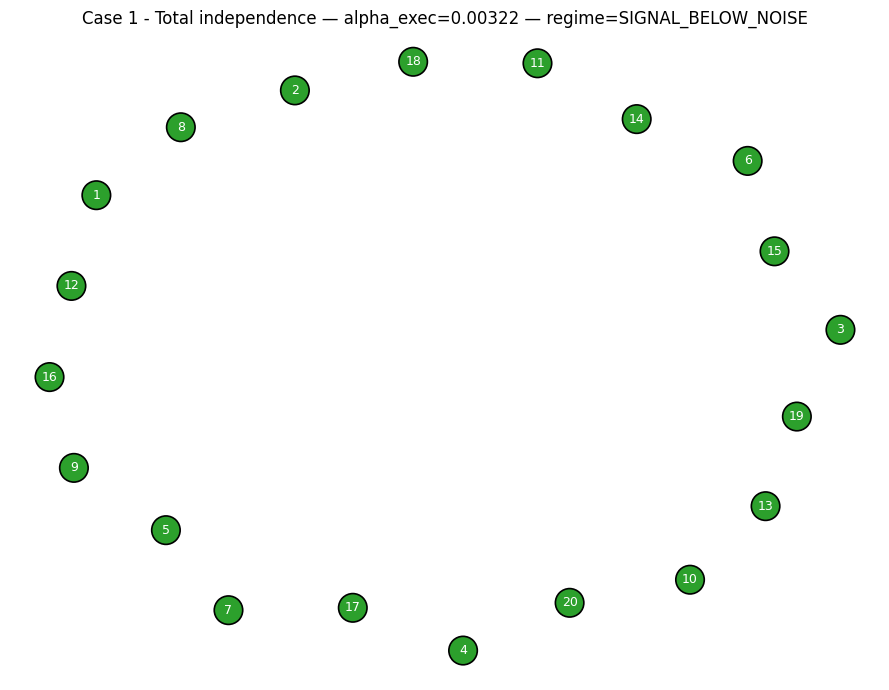




Case 2 - Total redundancy
[OK] Data generated: Y.shape = (1000, 20)

--- GROUND TRUTH ---
name: Case 2 - Total redundancy
intrinsic_dim_expected: 1
blocks_expected: [['f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'f17', 'f18', 'f19', 'f20']]
notes: A single latent; all objectives are noisy copies.

Condition: α_min = 0 and α_max > 0

Statistical regime: IMMEDIATE SEPARATION (id=3)

Interpretation: Structural dependencies are extremely robust; no lower limit was observed
 where the signal is lost.
Noise only begins to enter for α greater than α_max.

Action on MIS: Reduction allowed. Construct graph with an externally chosen α
(typically α_max), enumerate/rank MIS and use the highest ranked MIS
as surrogate.

Parameters (with Type I error intuition per test):
  α_min = 0  (N/A);  log10(α_min) = NaN
  α_max = 7.34719e-06  (≈ 1 in 136107);  log10(α_max) = -5.13388

Metrics:
  S = +inf  → S diverges (+inf) because α_min = 0; this 




Case 3 - Blocks (4 x 5)
[OK] Data generated: Y.shape = (1000, 20)

--- GROUND TRUTH ---
name: Case 3 - Blocks (4 x 5)
intrinsic_dim_expected: 4
blocks_expected: [['f1', 'f2', 'f3', 'f4', 'f5'], ['f6', 'f7', 'f8', 'f9', 'f10'], ['f11', 'f12', 'f13', 'f14', 'f15'], ['f16', 'f17', 'f18', 'f19', 'f20']]
notes: 4 independent latents; each generates 5 objectives (with noise).

Condition: α_min = 0 and α_max > 0

Statistical regime: IMMEDIATE SEPARATION (id=3)

Interpretation: Structural dependencies are extremely robust; no lower limit was observed
 where the signal is lost.
Noise only begins to enter for α greater than α_max.

Action on MIS: Reduction allowed. Construct graph with an externally chosen α
(typically α_max), enumerate/rank MIS and use the highest ranked MIS
as surrogate.

Parameters (with Type I error intuition per test):
  α_min = 0  (N/A);  log10(α_min) = NaN
  α_max = 7.1931e-06  (≈ 1 in 139022);  log10(α_max) = -5.14308

Metrics:
  S = +inf  → S diverges (+inf) because 

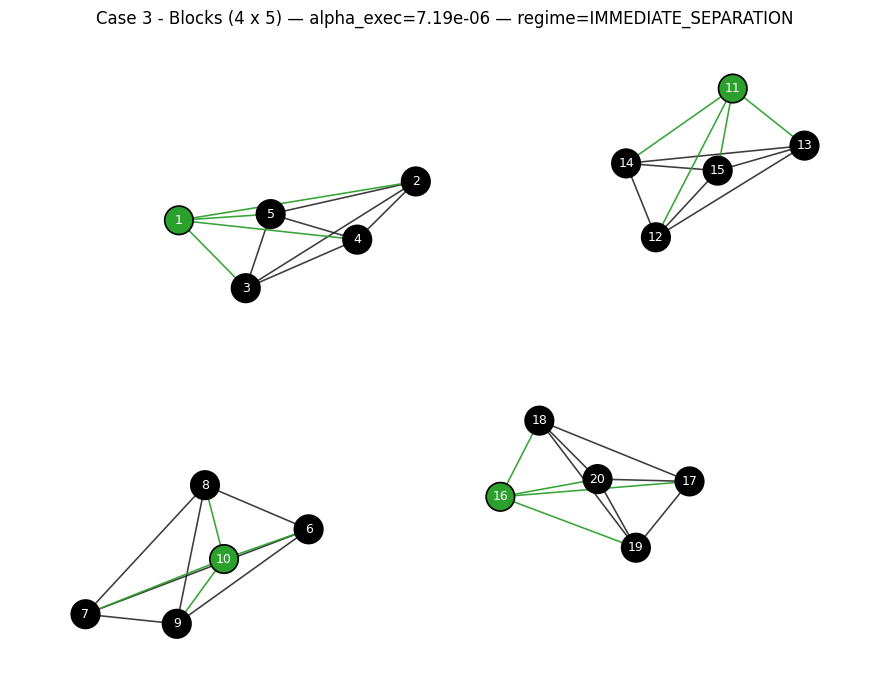




Case 4 - Blocks (2 x 10)
[OK] Data generated: Y.shape = (1000, 20)

--- GROUND TRUTH ---
name: Case 4 - Blocks (2 x 10)
intrinsic_dim_expected: 2
blocks_expected: [['f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10'], ['f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'f17', 'f18', 'f19', 'f20']]
notes: 2 independent latents; each generates 10 objectives (with noise).

Condition: α_min = 0 and α_max > 0

Statistical regime: IMMEDIATE SEPARATION (id=3)

Interpretation: Structural dependencies are extremely robust; no lower limit was observed
 where the signal is lost.
Noise only begins to enter for α greater than α_max.

Action on MIS: Reduction allowed. Construct graph with an externally chosen α
(typically α_max), enumerate/rank MIS and use the highest ranked MIS
as surrogate.

Parameters (with Type I error intuition per test):
  α_min = 0  (N/A);  log10(α_min) = NaN
  α_max = 7.40778e-06  (≈ 1 in 134993);  log10(α_max) = -5.13031

Metrics:
  S = +inf  → S diverges (+inf) because 

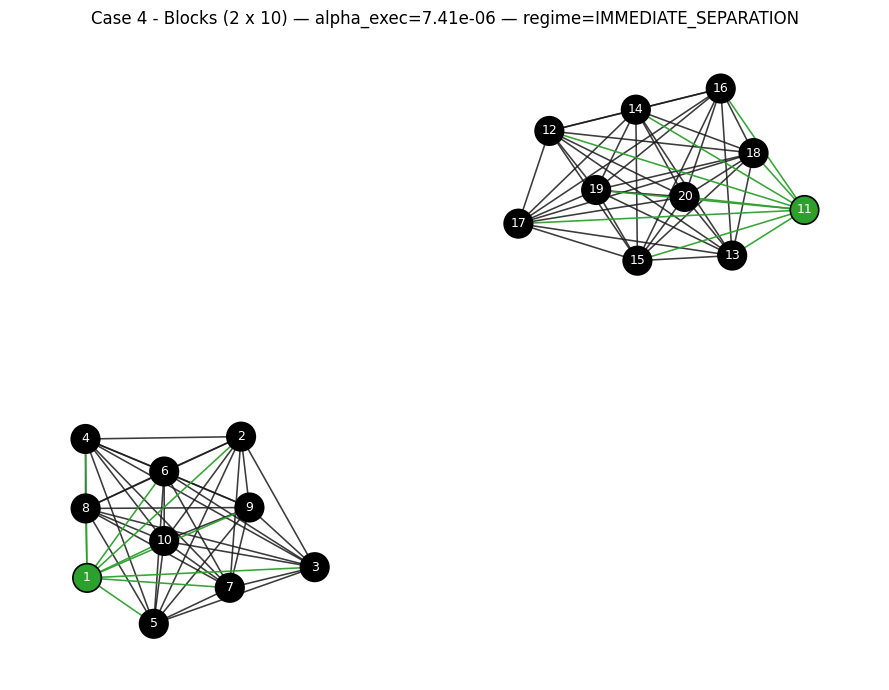




Case 5 - Chain
[OK] Data generated: Y.shape = (1000, 20)

--- GROUND TRUTH ---
name: Case 5 - Chain
intrinsic_dim_expected: 20
blocks_expected: [['f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'f17', 'f18', 'f19', 'f20']]
notes: Sequential dependency; no finite latent blocks (critical case for transitive correlation).

Condition: α_min = 0 and α_max > 0

Statistical regime: IMMEDIATE SEPARATION (id=3)

Interpretation: Structural dependencies are extremely robust; no lower limit was observed
 where the signal is lost.
Noise only begins to enter for α greater than α_max.

Action on MIS: Reduction allowed. Construct graph with an externally chosen α
(typically α_max), enumerate/rank MIS and use the highest ranked MIS
as surrogate.

Parameters (with Type I error intuition per test):
  α_min = 0  (N/A);  log10(α_min) = NaN
  α_max = 5.1428e-05  (≈ 1 in 19444.7);  log10(α_max) = -4.2888

Metrics:
  S = +inf  → S diverges (+inf) becau

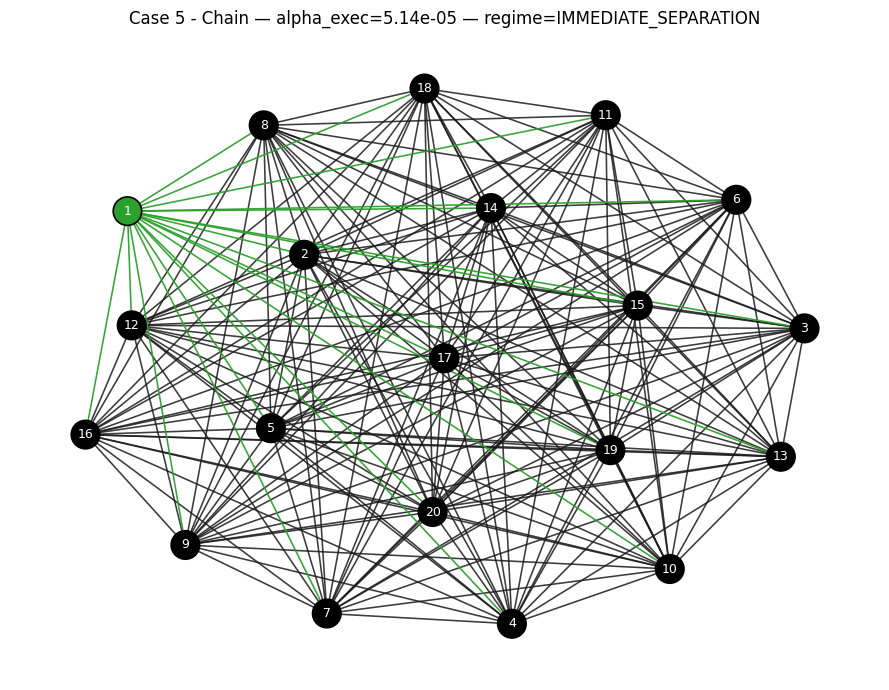




Case 6 - Mixed (indep + latents)
[OK] Data generated: Y.shape = (1000, 20)

--- GROUND TRUTH ---
name: Case 6 - Mixed (indep + latents)
intrinsic_dim_expected: 12
blocks_expected: [['f1'], ['f2'], ['f3'], ['f4'], ['f5'], ['f6'], ['f7'], ['f8'], ['f9'], ['f10'], ['f11', 'f12', 'f13', 'f14', 'f15'], ['f16', 'f17', 'f18', 'f19', 'f20']]
notes: f1..f10 independent; f11..f15 depend on latent1; f16..f20 depend on latent2.

Condition: α_min = 0 and α_max > 0

Statistical regime: IMMEDIATE SEPARATION (id=3)

Interpretation: Structural dependencies are extremely robust; no lower limit was observed
 where the signal is lost.
Noise only begins to enter for α greater than α_max.

Action on MIS: Reduction allowed. Construct graph with an externally chosen α
(typically α_max), enumerate/rank MIS and use the highest ranked MIS
as surrogate.

Parameters (with Type I error intuition per test):
  α_min = 0  (N/A);  log10(α_min) = NaN
  α_max = 3.53921e-07  (≈ 1 in 2.82549e+06);  log10(α_max) = -6.451




Case 7 - Structural conflict (anti-corr) with groups
[OK] Data generated: Y.shape = (1000, 20)

--- GROUND TRUTH ---
name: Case 7 - Structural conflict (anti-corr) 2-groups (M=20)
intrinsic_dim_expected: 2
blocks_expected: [['f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10'], ['f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'f17', 'f18', 'f19', 'f20']]
notes: Two internally redundant groups (+x and -x), but antagonistic to each other: conflict must be preserved.

Condition: α_min = 0 and α_max > 0

Statistical regime: IMMEDIATE SEPARATION (id=3)

Interpretation: Structural dependencies are extremely robust; no lower limit was observed
 where the signal is lost.
Noise only begins to enter for α greater than α_max.

Action on MIS: Reduction allowed. Construct graph with an externally chosen α
(typically α_max), enumerate/rank MIS and use the highest ranked MIS
as surrogate.

Parameters (with Type I error intuition per test):
  α_min = 0  (N/A);  log10(α_min) = NaN
  α_max = 7.0779

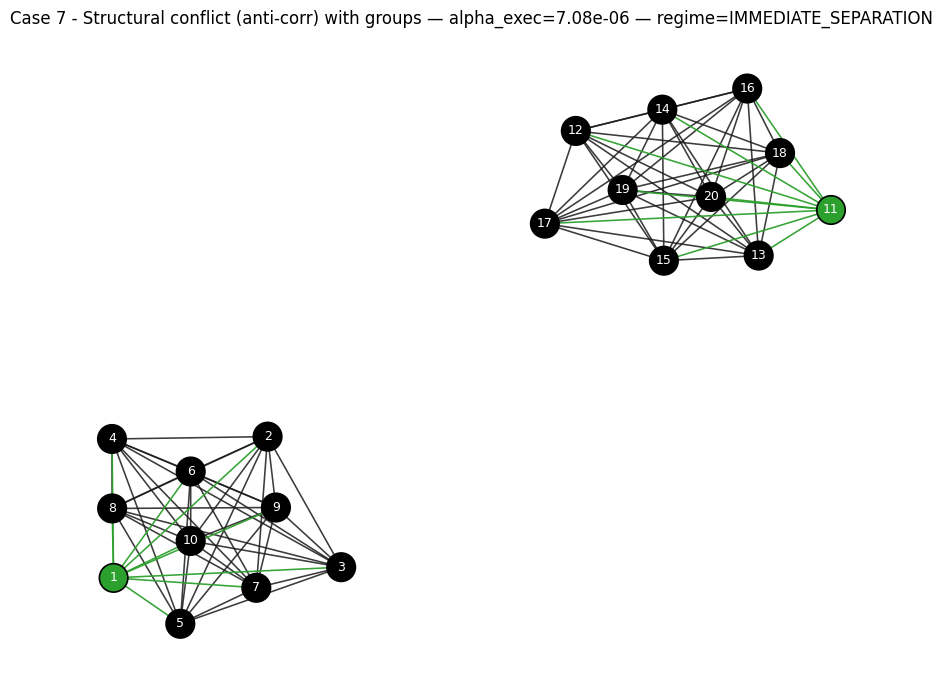

In [ ]:
# %%
# ## cell 4 - Execute ISDA on the 6 test cases (NOW WITH GROUND TRUTH)

def run_all_cases(alpha_viz=0.05, N=1000):
    cases = [
        ("Case 1 - Total independence", make_case1_independence),
        ("Case 2 - Total redundancy", make_case2_total_redundancy),
        ("Case 3 - Blocks (4 x 5)", make_case3_block_structure),
        ("Case 4 - Blocks (2 x 10)", make_case4_two_big_blocks),
        ("Case 5 - Chain", make_case5_chain_structure),
        ("Case 6 - Mixed (indep + latents)", make_case6_mixed_structure),
        ("Case 7 - Structural conflict (anti-corr) with groups", make_case7_pure_conflict_groups),
    ]

    all_results = {}

    for name, gen in cases:
        print("\n\n")
        print("=" * 70)
        print(name)
        print("=" * 70)

        # Now: gen returns (Y, truth)
        Y, truth = gen(N=N)
        print(f"[OK] Data generated: Y.shape = {Y.shape}")

        print("\n--- GROUND TRUTH ---")
        print(f"name: {truth['name']}")
        print(f"intrinsic_dim_expected: {truth['intrinsic_dim_expected']}")
        print(f"blocks_expected: {truth['blocks_expected']}")
        if truth.get("notes"):
            print(f"notes: {truth['notes']}")

        # 1) Estimate interval and diagnose regime
        alpha_min, alpha_max, r_max_real, r_max_null = estimate_alpha_interval(Y)

        metrics = diagnose_alpha_regime(alpha_min, alpha_max)
        regime = AlphaRegime(metrics["regime"])

        report = describe_alpha_regime(metrics)
        print(report)

        # 2) Decide whether reduction is applied, but still run for inspection
        reduction_applied = regime in (AlphaRegime.LIMINAL_SEPARATION, AlphaRegime.IMMEDIATE_SEPARATION)

        if reduction_applied:
            surrogate_final = "MIS_reduced (use highest ranked MIS)"
            alpha_exec = select_alpha(alpha_min, alpha_max, caution) # uses GLOBAL caution
            print(f"[DECISION] Reduction APPLIED. Final surrogate: {surrogate_final}")
            print("\n\nBELOW: THE DIMENSIONALLY REDUCTION RESULTS\n\n")
            print(f"[EXEC] alpha_exec (via select_alpha with caution={caution}) = {alpha_exec:.6g}")
        else:
            surrogate_final = "MIS_complete (all objectives; no reduction)"
            alpha_exec = max(alpha_min, alpha_max)
            print(f"[DECISION] Reduction NOT applied. Final surrogate: {surrogate_final}")
            print("\n\nFOR ILLUSTRATION ONLY: RESULT AS IF UNADVISED REDUCTION WERE APPLIED.\n\n")
            print(f"[EXEC] alpha_exec = {alpha_exec:.6g} (for inspection/visualization only; does not decide surrogate)")

        # 3) Execute ISDA
        res = isda_significance(Y, alpha=alpha_exec, print_report=True, name=name)

        # Now that 'res' (containing 'mis_ranked') is available, we can get best_mis and calculate lastro.
        best_mis = res["mis_ranked"][0]["mis_indices"] # Get the indices for the best MIS

        lastro = reduction_lastro(
          Y=Y,
          mis=best_mis,
          )

        print("\n--- LASTRO FOR REDUCTION (pre-result) ---")
        print(f"lastro_score = {lastro['lastro']:.4f}") # Changed from 'score' to 'lastro' based on reduction_lastro output
        # 'reasons' is not in the lastro dictionary, removing loop
        # for s in lastro["reasons"]:
        #   print(" - " + s)


        explain_lastro(lastro, name=name, top_k=10)

        # 4) Plot the graph
        viz = plot_custom_isda_graph(
            res,
            title=f"{name} — alpha_exec={alpha_exec:.3g} — regime={regime.name}",
            show_removed=False,
        )
        plt.show()
        plt.close(viz["fig"])

        # 5) Store everything (including truth)
        all_results[name] = {
            "truth": truth,
            "Y": Y,
            "regime": regime,
            "alpha_min": alpha_min,
            "alpha_max": alpha_max,
            "alpha_exec": alpha_exec,
            "reduction_applied": reduction_applied,
            "surrogate_final": surrogate_final,
            "results": res,
            "lastro": lastro, # Storing the entire lastro dict
            "best_mis": best_mis # Add best_mis here
        }

    return all_results


if __name__ == "__main__":
    results = run_all_cases(alpha_viz=0.05, N=1000)

# Test cases II

In [ ]:
# %%
# ============================================================
# Fabricated MOPs (A–F) — ALL with M=20 objectives
# Each function returns: (Y, truth)
# ============================================================

import numpy as np
import pandas as pd

def _mop_truth(name, intrinsic_dim_expected, blocks_expected, notes=""):
    return {
        "name": name,
        "intrinsic_dim_expected": int(intrinsic_dim_expected),
        "blocks_expected": blocks_expected,  # list of lists of names "f1","f2",...
        "notes": notes,
    }

def _mop_df(Y):
    return pd.DataFrame(Y, columns=[f"f{i+1}" for i in range(Y.shape[1])])

def _mk_block_names(start, size):
    # start is 1-based
    return [f"f{i}" for i in range(start, start + size)]

def _repeat_with_small_noise(base, rng, noise):
    # base: (N,) -> returns perturbed (N,)
    return base + noise * rng.normal(size=base.shape[0])


# ------------------------------------------------------------
# MOP-A — Monotonic redundancy (1D) with 20 objectives
# Expected: dim=1; single block of 20
# ------------------------------------------------------------
def mopA_monotonic_redundancy(N=1000, seed=123, noise=0.0):
    rng = np.random.default_rng(seed)
    x = rng.uniform(0.0, 1.0, size=N)

    # 20 monotonic transformations (all 1D redundant)
    feats = [
        x,
        2.0 * x + 0.1,
        np.log(1.0 + 9.0 * x),
        x**2,
        np.sqrt(np.maximum(x, 0.0)),
        x**3,
        np.exp(0.5 * x) - 1.0,
        1.0 / (1.0 + np.exp(-10.0 * (x - 0.5))),
        (x + 0.2) ** 2,
        np.log(1.0 + 3.0 * x),
        np.tanh(2.0 * x),
        (1.0 + x) ** 1.5,
        np.clip(x + 0.05, 0, 1),
        np.clip(1.2 * x, 0, 1),
        np.log1p(20.0 * x) / np.log1p(20.0),
        (x + 1e-6) ** 0.25,
        (x + 0.1) ** 3,
        np.sqrt(np.maximum(0.1 + x, 0.0)),
        np.exp(x) - 1.0,
        (x + 0.3) ** 2,
    ]
    Y = np.vstack([_repeat_with_small_noise(f, rng, noise) for f in feats]).T

    truth = _mop_truth(
        name="MOP-A — Monotonic redundancy (1D, M=20)",
        intrinsic_dim_expected=1,
        blocks_expected=[_mk_block_names(1, 20)],
        notes="20 objectives as monotonic (and redundant) transformations of the same latent x."
    )
    return _mop_df(Y), truth


def mopB_tradeoff_with_redundancies(N=1000, seed=123, noise=0.02):
    rng = np.random.default_rng(seed)
    a = rng.uniform(0.0, 1.0, size=N)
    b = rng.uniform(0.0, 1.0, size=N)

    # Plausible latents
    C = 0.6 * a + 0.8 * b            # cost in ~[0,1.4]
    E = b + 0.3 * (1.0 - a)          # consumption in ~[0,1.3]
    P = a * (1.0 - b) + 0.2 * a      # performance can go up to 1.2 -> BUG for Q

    # FIX: force performance to stay in [0,1] so that Q=1-P stays in [0,1]
    P = np.clip(P, 0.0, 1.0)
    Q = 1.0 - P

    # 7 "cost" objectives
    cost_feats = [
        C,
        _repeat_with_small_noise(C, rng, noise),
        1.0 + 2.0 * C,
        np.log1p(9.0 * C),
        np.sqrt(np.maximum(C, 0.0)),
        C**2,
        (C + 0.1) ** 1.5,
    ]

    # 7 "consumption" objectives
    cons_feats = [
        E,
        _repeat_with_small_noise(E, rng, noise),
        np.sqrt(np.maximum(E, 0.0)),
        np.log1p(9.0 * E),
        E**2,
        (E + 0.05),
        (E + 0.2) ** 1.3,
    ]

    # 6 "performance" objectives (minimization via 1-P), with protected domain
    Q_rep = np.clip(_repeat_with_small_noise(Q, rng, noise), 0.0, 1.0)

    perf_feats = [
        Q,
        Q_rep,
        Q**2,
        np.sqrt(np.maximum(Q, 0.0)),
        np.log1p(9.0 * Q),            # now Q ∈ [0,1] -> always valid
        (Q + 0.1) ** 1.2,             # now Q+0.1 ∈ [0.1,1.1] -> always valid
    ]

    feats = cost_feats + cons_feats + perf_feats
    Y = np.vstack(feats).T

    truth = _mop_truth(
        name="MOP-B — Trade-off + redundancies (~2D, M=20)",
        intrinsic_dim_expected=2,
        blocks_expected=[_mk_block_names(1, 7), _mk_block_names(8, 7), _mk_block_names(15, 6)],
        notes="Three families (cost/consumption/performance) with internal redundancies; effective tends to ~2."
    )
    return _mop_df(Y), truth



# ------------------------------------------------------------
# MOP-C — Latent blocks (4 independent factors) with 20 objectives
# Here: 4 blocks of 5 (total 20). Expected: dim=4.
# ------------------------------------------------------------
def mopC_latent_blocks_4x5(N=1000, seed=123, noise=0.02):
    rng = np.random.default_rng(seed)
    u, v, w, z = rng.uniform(0.0, 1.0, size=(4, N))
    eps = rng.normal(size=N)

    b1 = [u, 2*u, u**2, np.sqrt(np.maximum(u,0.0)), np.log1p(9*u)]
    b2 = [v, v+0.5, np.log1p(9*v), v**2, np.sqrt(np.maximum(v,0.0))]
    b3 = [w, w+noise*eps, np.sqrt(np.maximum(w,0.0)), np.log1p(9*w), (w+0.1)**2]
    b4 = [z, (1.0+z)**2, np.exp(z)-1.0, np.log1p(9*z), np.sqrt(np.maximum(z,0.0))]

    feats = b1 + b2 + b3 + b4
    Y = np.vstack(feats).T

    truth = _mop_truth(
        name="MOP-C — Latent blocks (4×5, M=20)",
        intrinsic_dim_expected=4,
        blocks_expected=[_mk_block_names(1,5), _mk_block_names(6,5), _mk_block_names(11,5), _mk_block_names(16,5)],
        notes="Four independent factors; each block (5 objectives) is internally redundant."
    )
    return _mop_df(Y), truth


# ------------------------------------------------------------
# MOP-D — Pure conflict (anti-corr) with 20 objectives
# Idea: 2 internally redundant groups (+x and 1-x), conflicting with each other.
# (This is, in practice, your Case 7 in 'MOP' format.)
# Expected: conflict must be preserved; internal redundancy can be reduced.
# ------------------------------------------------------------
def mopD_pure_conflict_groups(N=1000, seed=123, noise=0.0):
    rng = np.random.default_rng(seed)
    x = rng.uniform(0.0, 1.0, size=N)

    g1 = [
        x,
        2*x + 0.1,
        np.log1p(9*x),
        x**2,
        np.sqrt(np.maximum(x,0.0)),
        x**3,
        np.tanh(2*x),
        np.log1p(3*x),
        (x+0.2)**2,
        (1.0 + x)**1.5,
    ]
    y = 1.0 - x
    g2 = [
        y,
        2*y + 0.1,
        np.log1p(9*y),
        y**2,
        np.sqrt(np.maximum(y,0.0)),
        y**3,
        np.tanh(2*y),
        np.log1p(3*y),
        (y+0.2)**2,
        (1.0 + y)**1.5,
    ]

    feats = [_repeat_with_small_noise(f, rng, noise) for f in (g1 + g2)]
    Y = np.vstack(feats).T

    truth = _mop_truth(
        name="MOP-D — Structural conflict (anti-corr) 2-groups (M=20)",
        intrinsic_dim_expected=2,
        blocks_expected=[_mk_block_names(1,10), _mk_block_names(11,10)],
        notes="Two internally redundant groups (+x and 1-x), but antagonistic to each other: conflict must be preserved."
    )
    return _mop_df(Y), truth


# ------------------------------------------------------------
# MOP-E — Partial redundancy + noise + new objective + mixtures with 20 objectives
# Here: three subfamilies (10 + 4 + 6 = 20) maintaining the original idea.
# Expected: dim≈2 (maintained).
# ------------------------------------------------------------
def mopE_partial_redundancy_noisy(N=1000, seed=123, noise=0.05):
    rng = np.random.default_rng(seed)
    a = rng.uniform(0.0, 1.0, size=N)
    b = rng.uniform(0.0, 1.0, size=N)
    eps = rng.normal(size=N)

    # subfamily A: redundant around 'a' (10)
    A = [
        a,
        a + noise*eps,
        a - noise*eps,
        2*a + 0.1,
        a**2,
        np.sqrt(np.maximum(a,0.0)),
        np.log1p(9*a),
        (a+0.2)**2,
        np.tanh(2*a),
        (1.0+a)**1.2,
    ]

    # subfamily B: "b" (4)
    B = [
        b,
        b + 0.5,
        np.sqrt(np.maximum(b,0.0)),
        np.log1p(9*b),
    ]

    # mixtures/compounds: functions of s=a+b (6)
    s = a + b
    C = [
        s,
        s**2,
        np.sqrt(np.maximum(s,0.0)),
        np.log1p(9*s),
        (s+0.1)**1.5,
        1.0/(1.0+np.exp(-10*(s-1.0))),
    ]

    feats = A + B + C
    Y = np.vstack(feats).T

    truth = _mop_truth(
        name="MOP-E — Partial redundancy + noise (M=20)",
        intrinsic_dim_expected=2,
        blocks_expected=[_mk_block_names(1,10), _mk_block_names(11,4), _mk_block_names(15,6)],
        notes="Trio/quartet of 'a' extended to 10 redundants; 'b' (4); and 6 compounds around s=a+b."
    )
    return _mop_df(Y), truth


# ------------------------------------------------------------
# MOP-F — Regimes (mixture) with 20 objectives
# Here: 10 objectives based on L (mixture by regime) + 10 based on b
# Expected: dim≈2 (maintained), but global correlation can be misleading.
# ------------------------------------------------------------
def mopF_regime_switching(N=1000, seed=123, sharpness=20.0, noise=0.0):
    rng = np.random.default_rng(seed)
    a = rng.uniform(0.0, 1.0, size=N)
    b = rng.uniform(0.0, 1.0, size=N)

    s = 1.0 / (1.0 + np.exp(-sharpness * (a - 0.5)))
    L = (1.0 - s) * a + s * b

    eps = rng.normal(size=N)

    L_feats = [
        L,
        L**2,
        np.log1p(9*L),
        np.sqrt(np.maximum(L,0.0)),
        (L+0.1)**1.5,
        np.tanh(2*L),
        np.exp(0.5*L)-1.0,
        (L+0.2)**2,
        np.log1p(3*L),
        _repeat_with_small_noise(L, rng, 0.02) if noise == 0.0 else _repeat_with_small_noise(L, rng, noise),
    ]

    b_feats = [
        b,
        np.sqrt(np.maximum(b,0.0)),
        np.log1p(9*b),
        b**2,
        (b+0.1)**1.5,
        np.tanh(2*b),
        np.exp(0.5*b)-1.0,
        (b+0.2)**2,
        np.log1p(3*b),
        _repeat_with_small_noise(b, rng, 0.02) if noise == 0.0 else _repeat_with_small_noise(b, rng, noise),
    ]

    feats = L_feats + b_feats
    Y = np.vstack(feats).T

    truth = _mop_truth(
        name="MOP-F — Regimes (mixture, M=20)",
        intrinsic_dim_expected=2,
        blocks_expected=[_mk_block_names(1,10), _mk_block_names(11,10)],
        notes="10 objectives redundant around L (mixture by regime) + 10 redundant around b; global correlation can be misleading."
    )
    return _mop_df(Y), truth


# ------------------------------------------------------------
# List of MOPs (for the execution cell)
# ------------------------------------------------------------
MOP_CASES = [
    ("MOP-A — Monotonic redundancy", mopA_monotonic_redundancy),
    ("MOP-B — Trade-off", mopB_tradeoff_with_redundancies),
    ("MOP-C — Latent blocks (4×5)", mopC_latent_blocks_4x5),
    ("MOP-D — Structural conflict", mopD_pure_conflict_groups),
    ("MOP-E — Partial redundancy", mopE_partial_redundancy_noisy),
    ("MOP-F — Regimes", mopF_regime_switching),
]

# Run test cases II




MOP-A — Monotonic redundancy
[OK] Data generated: Y.shape = (1000, 20)

--- GROUND TRUTH ---
name: MOP-A — Monotonic redundancy (1D, M=20)
intrinsic_dim_expected: 1
blocks_expected: [['f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'f17', 'f18', 'f19', 'f20']]
notes: 20 objectives as monotonic (and redundant) transformations of the same latent x.

Condition: 0 < α_min ≤ α_max

Statistical regime: LIMINAL SEPARATION (id=4)

Interpretation: There is a statistically valid interval: below α_min the
 signal begins to be lost, and above α_max noise begins to enter.

Action on MIS: Reduction allowed. Construct graph with an externally chosen α
 (typically α_max) enumerate/rank MIS and use 
the highest ranked MIS as surrogate.

Parameters (with Type I error intuition per test):
  α_min = 1e-12  (≈ 1 in 1e+12);  log10(α_min) = -12
  α_max = 7.15751e-06  (≈ 1 in 139713);  log10(α_max) = -5.14524

Metrics:
  S = 15.7837  → S = log(α_max/α_




MOP-B — Trade-off
[OK] Data generated: Y.shape = (1000, 20)

--- GROUND TRUTH ---
name: MOP-B — Trade-off + redundancies (~2D, M=20)
intrinsic_dim_expected: 2
blocks_expected: [['f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7'], ['f8', 'f9', 'f10', 'f11', 'f12', 'f13', 'f14'], ['f15', 'f16', 'f17', 'f18', 'f19', 'f20']]
notes: Three families (cost/consumption/performance) with internal redundancies; effective tends to ~2.

Condition: 0 < α_min ≤ α_max

Statistical regime: LIMINAL SEPARATION (id=4)

Interpretation: There is a statistically valid interval: below α_min the
 signal begins to be lost, and above α_max noise begins to enter.

Action on MIS: Reduction allowed. Construct graph with an externally chosen α
 (typically α_max) enumerate/rank MIS and use 
the highest ranked MIS as surrogate.

Parameters (with Type I error intuition per test):
  α_min = 1e-12  (≈ 1 in 1e+12);  log10(α_min) = -12
  α_max = 1.5877e-05  (≈ 1 in 62984.3);  log10(α_max) = -4.79923

Metrics:
  S = 16.5804  → S 

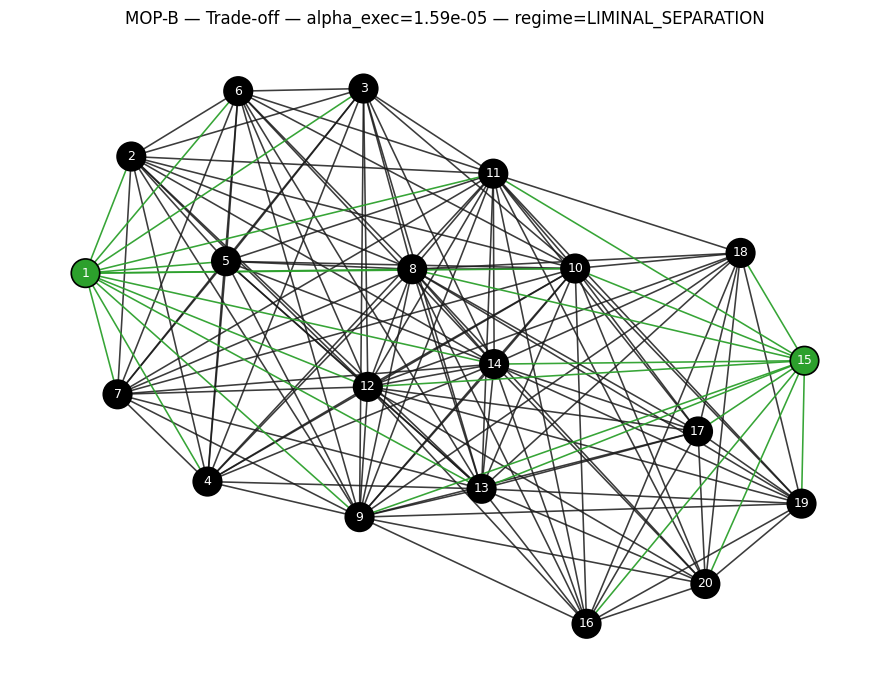




MOP-C — Latent blocks (4×5)
[OK] Data generated: Y.shape = (1000, 20)

--- GROUND TRUTH ---
name: MOP-C — Latent blocks (4×5, M=20)
intrinsic_dim_expected: 4
blocks_expected: [['f1', 'f2', 'f3', 'f4', 'f5'], ['f6', 'f7', 'f8', 'f9', 'f10'], ['f11', 'f12', 'f13', 'f14', 'f15'], ['f16', 'f17', 'f18', 'f19', 'f20']]
notes: Four independent factors; each block (5 objectives) is internally redundant.

Condition: 0 < α_min ≤ α_max

Statistical regime: LIMINAL SEPARATION (id=4)

Interpretation: There is a statistically valid interval: below α_min the
 signal begins to be lost, and above α_max noise begins to enter.

Action on MIS: Reduction allowed. Construct graph with an externally chosen α
 (typically α_max) enumerate/rank MIS and use 
the highest ranked MIS as surrogate.

Parameters (with Type I error intuition per test):
  α_min = 1e-12  (≈ 1 in 1e+12);  log10(α_min) = -12
  α_max = 1.77155e-05  (≈ 1 in 56447.8);  log10(α_max) = -4.75165

Metrics:
  S = 16.69  → S = log(α_max/α_min) m




MOP-D — Structural conflict
[OK] Data generated: Y.shape = (1000, 20)

--- GROUND TRUTH ---
name: MOP-D — Structural conflict (anti-corr) 2-groups (M=20)
intrinsic_dim_expected: 2
blocks_expected: [['f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10'], ['f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'f17', 'f18', 'f19', 'f20']]
notes: Two internally redundant groups (+x and 1-x), but antagonistic to each other: conflict must be preserved.

Condition: 0 < α_min ≤ α_max

Statistical regime: LIMINAL SEPARATION (id=4)

Interpretation: There is a statistically valid interval: below α_min the
 signal begins to be lost, and above α_max noise begins to enter.

Action on MIS: Reduction allowed. Construct graph with an externally chosen α
 (typically α_max) enumerate/rank MIS and use 
the highest ranked MIS as surrogate.

Parameters (with Type I error intuition per test):
  α_min = 1e-12  (≈ 1 in 1e+12);  log10(α_min) = -12
  α_max = 1.84158e-05  (≈ 1 in 54301.2);  log10(α_max) = -4.73481


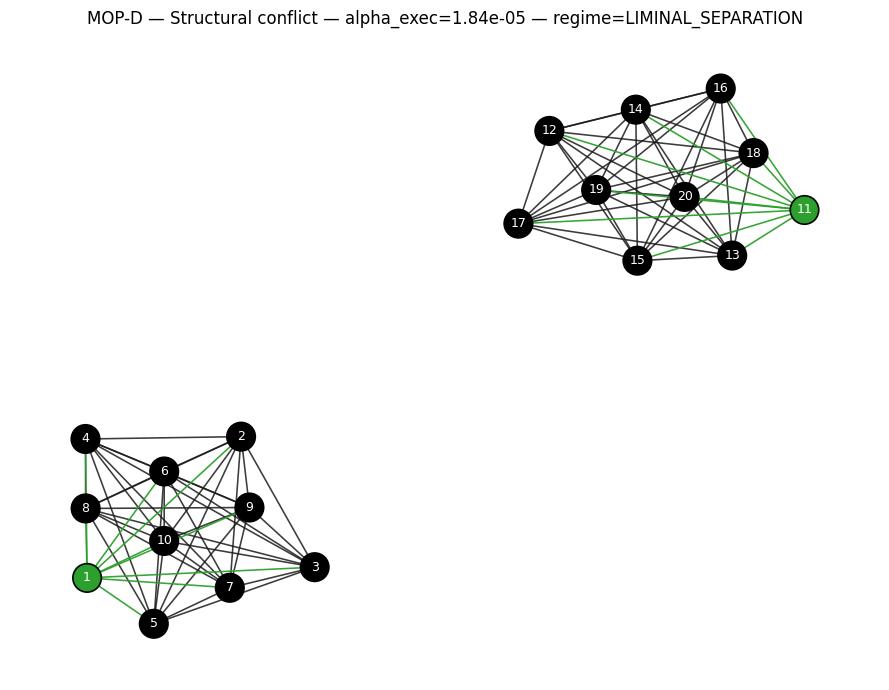




MOP-E — Partial redundancy
[OK] Data generated: Y.shape = (1000, 20)

--- GROUND TRUTH ---
name: MOP-E — Partial redundancy + noise (M=20)
intrinsic_dim_expected: 2
blocks_expected: [['f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10'], ['f11', 'f12', 'f13', 'f14'], ['f15', 'f16', 'f17', 'f18', 'f19', 'f20']]
notes: Trio/quartet of 'a' extended to 10 redundants; 'b' (4); and 6 compounds around s=a+b.

Condition: 0 < α_min ≤ α_max

Statistical regime: LIMINAL SEPARATION (id=4)

Interpretation: There is a statistically valid interval: below α_min the
 signal begins to be lost, and above α_max noise begins to enter.

Action on MIS: Reduction allowed. Construct graph with an externally chosen α
 (typically α_max) enumerate/rank MIS and use 
the highest ranked MIS as surrogate.

Parameters (with Type I error intuition per test):
  α_min = 1e-12  (≈ 1 in 1e+12);  log10(α_min) = -12
  α_max = 2.16121e-05  (≈ 1 in 46270.4);  log10(α_max) = -4.6653

Metrics:
  S = 16.8888  → S = log

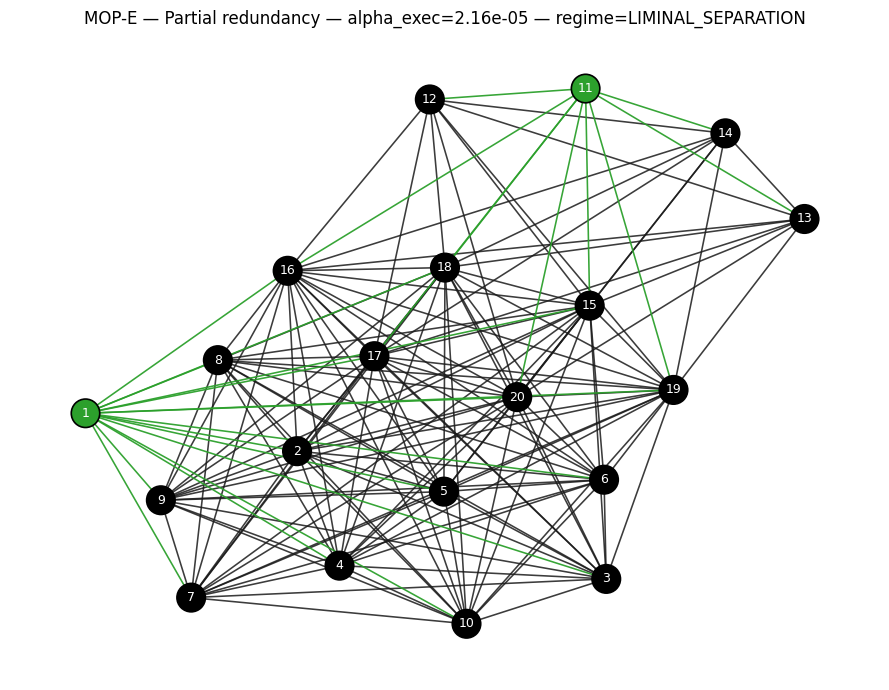




MOP-F — Regimes
[OK] Data generated: Y.shape = (1000, 20)

--- GROUND TRUTH ---
name: MOP-F — Regimes (mixture, M=20)
intrinsic_dim_expected: 2
blocks_expected: [['f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10'], ['f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'f17', 'f18', 'f19', 'f20']]
notes: 10 objectives redundant around L (mixture by regime) + 10 redundant around b; global correlation can be misleading.

Condition: α_min = 0 and α_max > 0

Statistical regime: IMMEDIATE SEPARATION (id=3)

Interpretation: Structural dependencies are extremely robust; no lower limit was observed
 where the signal is lost.
Noise only begins to enter for α greater than α_max.

Action on MIS: Reduction allowed. Construct graph with an externally chosen α
(typically α_max), enumerate/rank MIS and use the highest ranked MIS
as surrogate.

Parameters (with Type I error intuition per test):
  α_min = 0  (N/A);  log10(α_min) = NaN
  α_max = 9.9619e-06  (≈ 1 in 100382);  log10(α_max) = -5.00166

Me

In [ ]:
# %%
# ============================================================
# Independent Runner: executes ONLY fabricated MOPs (A–F)
# Uses the same pipeline/visualization as run_all_cases,
# but does not interfere with cases 1–6.
# ============================================================

def run_mop_cases(alpha_viz=0.05, N=1000):
    all_results = {}

    for name, gen in MOP_CASES:
        print("\n\n")
        print("=" * 70)
        print(name)
        print("=" * 70)

        # (Y, truth) — tolerates larger returns and ignores the rest
        out = gen(N=N)
        if not isinstance(out, tuple) or len(out) < 2:
            raise ValueError(f"{name}: generator must return (Y, truth). Received: {type(out)} len={len(out) if isinstance(out, tuple) else 'N/A'}")
        Y, truth = out[0], out[1]

        print(f"[OK] Data generated: Y.shape = {Y.shape}")

        print("\n--- GROUND TRUTH ---")
        print(f"name: {truth.get('name')}")
        print(f"intrinsic_dim_expected: {truth.get('intrinsic_dim_expected')}")
        print(f"blocks_expected: {truth.get('blocks_expected')}")
        if truth.get("notes"):
            print(f"notes: {truth.get('notes')}")

        # 1) Estimate interval and diagnose regime
        alpha_min, alpha_max, r_max_real, r_max_null = estimate_alpha_interval(Y)

        metrics = diagnose_alpha_regime(alpha_min, alpha_max)
        regime = AlphaRegime(metrics["regime"])

        report = describe_alpha_regime(metrics)
        print(report)

        # 2) Decide if reduction is applied (same logic)
        reduction_applied = regime in (AlphaRegime.LIMINAL_SEPARATION, AlphaRegime.IMMEDIATE_SEPARATION)

        if reduction_applied:
            surrogate_final = "MIS_reduced (use highest ranked MIS)"
            alpha_exec = select_alpha(alpha_min, alpha_max, caution=caution)  # uses GLOBAL caution
            print(f"[DECISION] Reduction APPLIED. Final surrogate: {surrogate_final}")
            print("\n\nBELOW: THE DIMENSIONALLY REDUCTION RESULTS\n\n")
            print(f"[EXEC] alpha_exec (via select_alpha with caution={caution}) = {alpha_exec:.6g}")
        else:
            surrogate_final = "MIS_complete (all objectives; no reduction)"
            alpha_exec = max(alpha_min, alpha_max)
            print(f"[DECISION] Reduction NOT applied. Final surrogate: {surrogate_final}")
            print("\n\nFOR ILLUSTRATION ONLY: RESULT AS IF UNADVISED REDUCTION WERE APPLIED.\n\n")
            print(f"[EXEC] alpha_exec = {alpha_exec:.6g} (for inspection/visualization only; does not decide surrogate)")

        # 3) Execute ISDA
        res = isda_significance(Y, alpha=alpha_exec, print_report=True, name=name)

        # Now that 'res' (containing 'mis_ranked') is available, we can get best_mis and calculate lastro.
        best_mis = res["mis_ranked"][0]["mis_indices"] # Get the indices for the best MIS

        lastro = reduction_lastro(
          Y=Y,
          mis=best_mis,
          )
        print("\n--- LASTRO FOR REDUCTION (pre-result) ---")
        print(f"lastro_score = {lastro['lastro']:.4f}") # Changed from 'score' to 'lastro'
        # 'reasons' is not in the lastro dictionary, removing loop
        # for s in lastro["reasons"]:
        #   print(" - " + s)

        explain_lastro(lastro, name=name, top_k=10)

        # 4) Plot the graph
        viz = plot_custom_isda_graph(
            res,
            title=f"{name} — alpha_exec={alpha_exec:.3g} — regime={regime.name}",
            show_removed=False,
        )
        plt.show()
        plt.close(viz["fig"])

        # 5) Store everything
        all_results[name] = {
            "truth": truth,
            "Y": Y,
            "regime": regime,
            "alpha_min": alpha_min,
            "alpha_max": alpha_max,
            "alpha_exec": alpha_exec,
            "reduction_applied": reduction_applied,
            "surrogate_final": surrogate_final,
            "results": res,
            "lastro": lastro, # Storing the entire lastro dict
            "best_mis": best_mis # Add best_mis here
        }

    return all_results


if __name__ == "__main__":
    mop_results = run_mop_cases(alpha_viz=0.05, N=1000)

# Empirical verification

In [ ]:
import numpy as np
import pandas as pd

def calculate_reconstruction_fidelity(
    Y,
    mis_indices,
    test_size: float = 0.3,
    seed: int = 123,
):
    """
    Calculates the reconstruction fidelity (average R-squared) for a given MIS set.

    This function uses `reduction_lastro` to evaluate how well non-MIS objectives
    can be reconstructed from the MIS objectives.

    Parameters
    ----------
    Y : np.ndarray or pd.DataFrame
        The original dataset (N samples x M objectives).
    mis_indices : list
        A list of (0-based) indices of the objectives that form the MIS.
    test_size : float, optional
        Proportion of the dataset to be used as the test set. Default is 0.3.
    seed : int, optional
        Seed for reproducibility of the train/test split. Default is 123.

    Returns
    -------
    float
        The F_real value, which represents the average R-squared of the reconstruction.
    """
    # Ensure mis_indices is not empty, as reduction_lastro expects this.
    if not mis_indices:
        # If there is no MIS to reconstruct, fidelity is 0
        # or can be interpreted differently, depending on the context.
        # For this case, we return 0, as there is nothing to reconstruct.
        return 0.0

    # Call the reduction_lastro function
    # Note: reduction_lastro expects a list of indices for 'mis'
    lastro_results = reduction_lastro(
        Y=Y,
        mis=mis_indices,
        n_perm=1,  # Only 1 permutation to save time, as we only need F_real
        test_size=test_size,
        seed=seed,
        clip=False, # No need to clip if only F_real is used
        return_details=True
    )

    # Extract and return F_real
    return lastro_results["F_real"]

In [ ]:
import pandas as pd

def evaluate_mop_cases_fidelity(mop_results):
    results_summary = []

    for name, data in mop_results.items():
        Y = data["Y"]
        mis_indices = data["best_mis"]
        truth = data["truth"]

        # Calculate reconstruction fidelity using the newly defined function
        fidelity = calculate_reconstruction_fidelity(Y, mis_indices)

        # Extract relevant information
        expected_dim = truth["intrinsic_dim_expected"]
        mis_size = len(mis_indices) if mis_indices else 0

        results_summary.append({
            "Case": name,
            "Expected Intrinsic Dim": expected_dim,
            "Selected MIS Size": mis_size,
            "Reconstruction Fidelity (F_real)": fidelity
        })

    df_summary = pd.DataFrame(results_summary)
    print("\n--- ISDA Reconstruction Fidelity Evaluation for MOP Cases ---")
    print(df_summary.to_markdown(index=False))
    return df_summary

# Assuming mop_results was generated by run_mop_cases
# If run_mop_cases was not executed, this cell would fail.
# I'm assuming it has been executed based on the previous context.
if 'mop_results' in locals():
    mop_fidelity_df = evaluate_mop_cases_fidelity(mop_results)
else:
    print("Error: mop_results DataFrame not found. Please run the MOP cases first.")


--- ISDA Reconstruction Fidelity Evaluation for MOP Cases ---
| Case                         |   Expected Intrinsic Dim |   Selected MIS Size |   Reconstruction Fidelity (F_real) |
|:-----------------------------|-------------------------:|--------------------:|-----------------------------------:|
| MOP-A — Monotonic redundancy |                        1 |                   1 |                           0.944602 |
| MOP-B — Trade-off            |                        2 |                   2 |                           0.952367 |
| MOP-C — Latent blocks (4×5)  |                        4 |                   4 |                           0.949512 |
| MOP-D — Structural conflict  |                        2 |                   2 |                           0.942593 |
| MOP-E — Partial redundancy   |                        2 |                   2 |                           0.956678 |
| MOP-F — Regimes              |                        2 |                   1 |                       

**Reasoning**:
To comply with the subtask's first instruction, I need to iterate through all cells in the notebook and extract their content and cell IDs. I will then initialize a list to store any detected Portuguese content.



In [ ]:
import re

portuguese_findings = []

# Define some common Portuguese words or patterns to look for as a heuristic
portuguese_keywords = [
    "básicos", "mês", "ões", "ção", "ões", "ção", "ções",
    "ainda", "mais", "para", "pelo", "pela", "pelos", "pelas",
    "este", "esta", "estes", "estas", "esse", "essa", "esses", "essas",
    "que", "com", "não", "um", "uma", "os", "as", "no", "na",
    "por", "em", "de", "do", "da", "dos", "das", "ou", "e", "é",
    "são", "mas", "se", "ele", "ela", "eles", "elas", "você",
    "nós", "vos", "meu", "minha", "teu", "tua", "seu", "sua"
]

for cell in notebook.cells:
    cell_content = "".join(cell.content) # Join list of strings into a single string
    cell_id = cell.cell_id

    found_portuguese_in_cell = []
    for keyword in portuguese_keywords:
        # Case-insensitive search for keywords
        matches = re.findall(r'\b' + re.escape(keyword) + r'\b', cell_content, re.IGNORECASE)
        if matches:
            # Store unique matches to avoid duplicates for the same keyword in a cell
            found_portuguese_in_cell.extend(list(set(matches)))

    if found_portuguese_in_cell:
        # Ensure unique findings for the cell and store them
        portuguese_findings.append({"cell_id": cell_id, "portuguese_text": list(set(found_portuguese_in_cell))})


if portuguese_findings:
    print("Portuguese content found:")
    for item in portuguese_findings:
        print(f"  Cell ID: {item['cell_id']}")
        print(f"    Found text: {item['portuguese_text']}")
else:
    print("No Portuguese content found in the notebook.")

print("List of findings stored in 'portuguese_findings' variable.")

NameError: name 'notebook' is not defined